<a href="https://colab.research.google.com/github/stanislavlia/machinelearning_algorithms/blob/main/DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
#load MNIST

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

#Normalizing the images to be between [-1, 1]

train_images = (train_images - 127.5) / 127.5

## The generator model

In [80]:
def make_generator_model():
    #takes a (100,) dimensional random noise vec

    generator_model = tf.keras.Sequential(
        [
            layers.Dense(units=256*7*7, use_bias=False, input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Reshape((7, 7, 256)),

            layers.Conv2DTranspose(128, (5,5), strides=(1, 1), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="tanh")

        ],
        name="Generator"

    )

    return generator_model

In [81]:
make_generator_model().summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_33 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_11 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_33 (Conv2  (None, 7, 7, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_34 (Ba  (None, 7, 7, 128)         51

### Discriminator model

In [82]:


def make_discriminator_model():

    discriminator_model = tf.keras.Sequential(
        [
            layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Flatten(),
            layers.Dropout(0.4),
            layers.Dense(128, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(1, activation='linear')

        ],
        name="Discriminator"
    )
    return discriminator_model

In [83]:
make_discriminator_model().summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_33 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_34 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_11 (Flatten)        (None, 6272)            

### Define the loss

In [84]:
cross_entropy = BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = (real_loss + fake_loss)

    return total_loss


def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    return fake_loss

In [85]:
def visualize_generated_images(generated_images,  num_samples=16):
    """
    Visualize images generated by the GAN's generator.

    Parameters:
    - generator_model: The generator model
    - noise_dim: Dimension of the random noise vector
    - num_samples: Number of samples to generate and visualize
    """


    # Plot the generated images
    fig, axes = plt.subplots(nrows=int(num_samples**0.5), ncols=int(num_samples**0.5), figsize=(10, 10),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for i, ax in enumerate(axes.flat):
        # Reshape the image to 28x28
        img = tf.reshape(generated_images[i], (28, 28))
        ax.imshow(img, cmap='gray')


    plt.show()


In [87]:
#TRAINING HYPERPARAMS

EPOCHS = 60
noise_dim = 100
BATCH_SIZE = 256


#models
generator = make_generator_model()
discriminator = make_discriminator_model()

#Optimizers
G_optimizer = Adam(0.0002)
D_optimizer = Adam(0.0002)

n_batches = train_images.shape[0] // 256


In [88]:

#SET up a checkpoints for safe training

base_dir = '/content/drive/MyDrive/Colab Notebooks/'


checkpoint_dir = os.path.join(base_dir, 'train_checkpoints')
chck_prefix = os.path.join(checkpoint_dir, "ckpt")
print(chck_prefix)

checkpoint = tf.train.Checkpoint(generator_optimizer=G_optimizer,
                                 discriminator_optimizer=D_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)


/content/drive/MyDrive/Colab Notebooks/train_checkpoints/ckpt


(16, 28, 28, 1)
EPOCH # 0
Generated images:


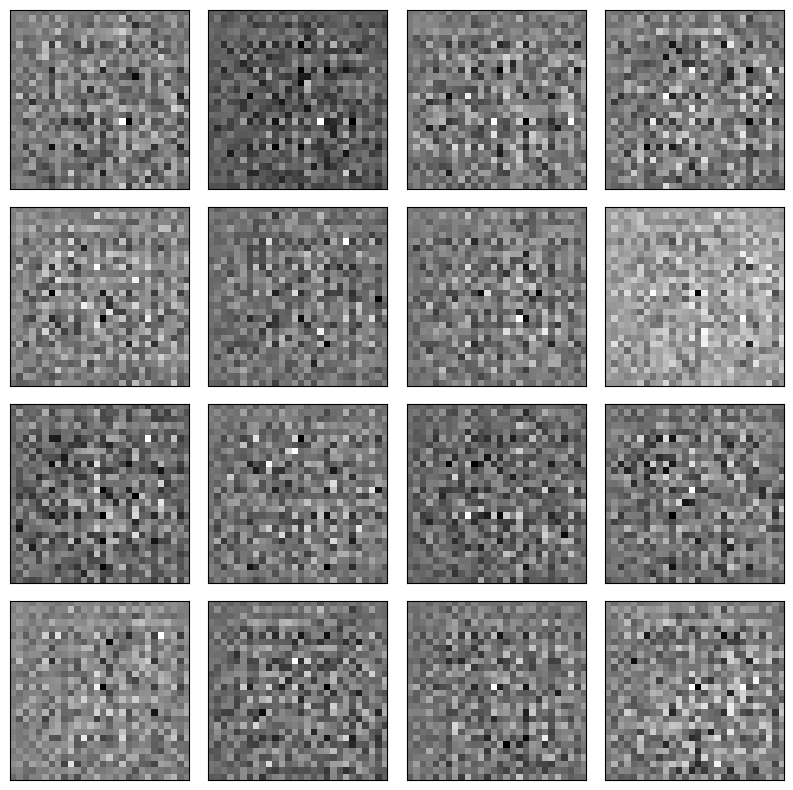




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 0; D_loss=0.27727389335632324; G_loss=3.7807161808013916
(16, 28, 28, 1)
EPOCH # 1
Generated images:


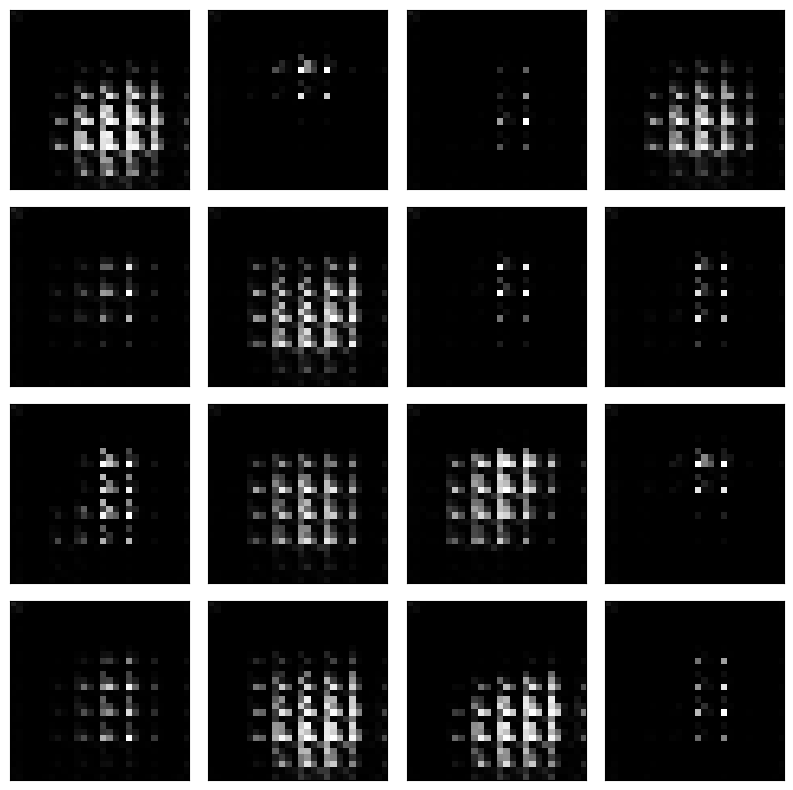




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 1; D_loss=0.6772713661193848; G_loss=5.465476989746094
(16, 28, 28, 1)
EPOCH # 2
Generated images:


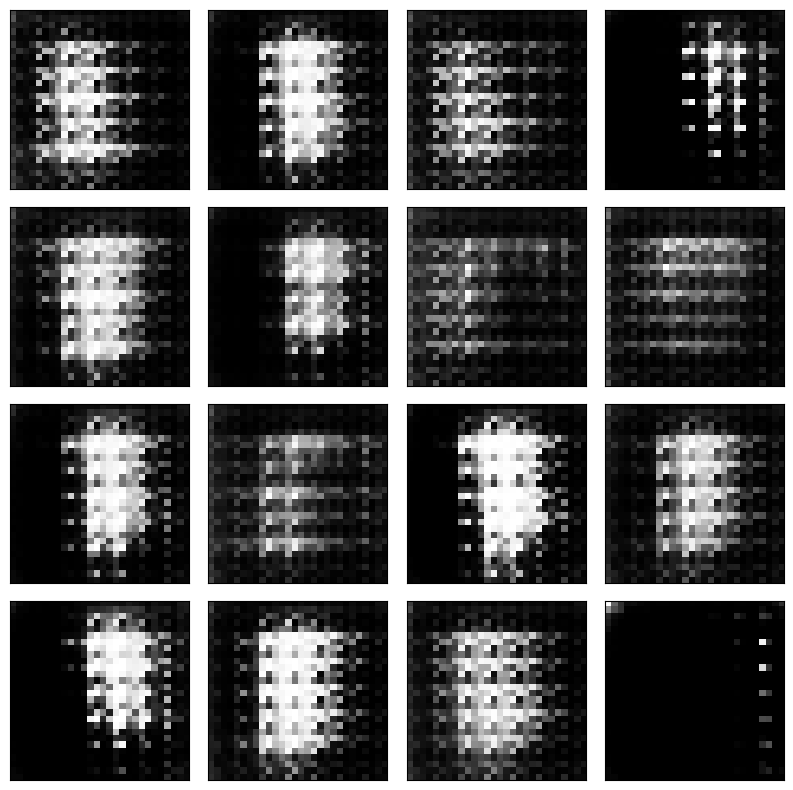




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 2; D_loss=0.37224429845809937; G_loss=3.2908132076263428
(16, 28, 28, 1)
EPOCH # 3
Generated images:


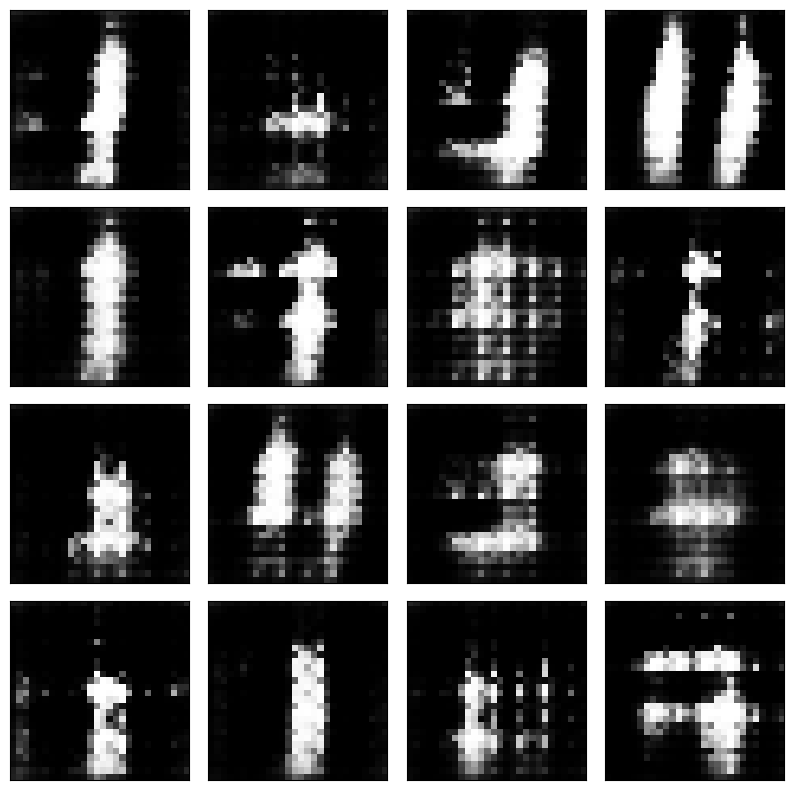




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 3; D_loss=0.289553701877594; G_loss=2.868114948272705
(16, 28, 28, 1)
EPOCH # 4
Generated images:


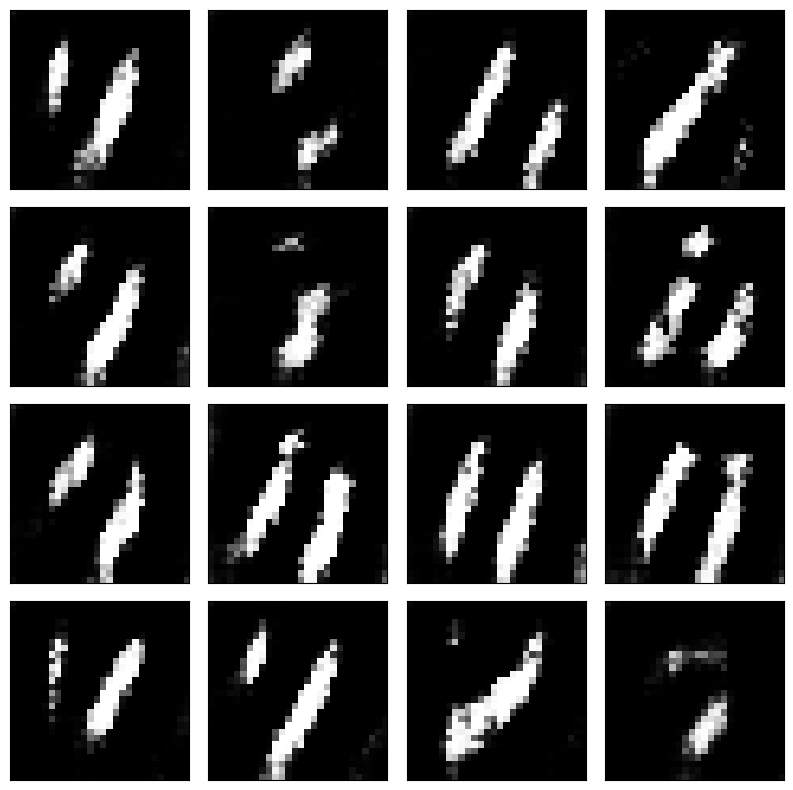




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 4; D_loss=0.738582968711853; G_loss=2.268434762954712
(16, 28, 28, 1)
EPOCH # 5
Generated images:


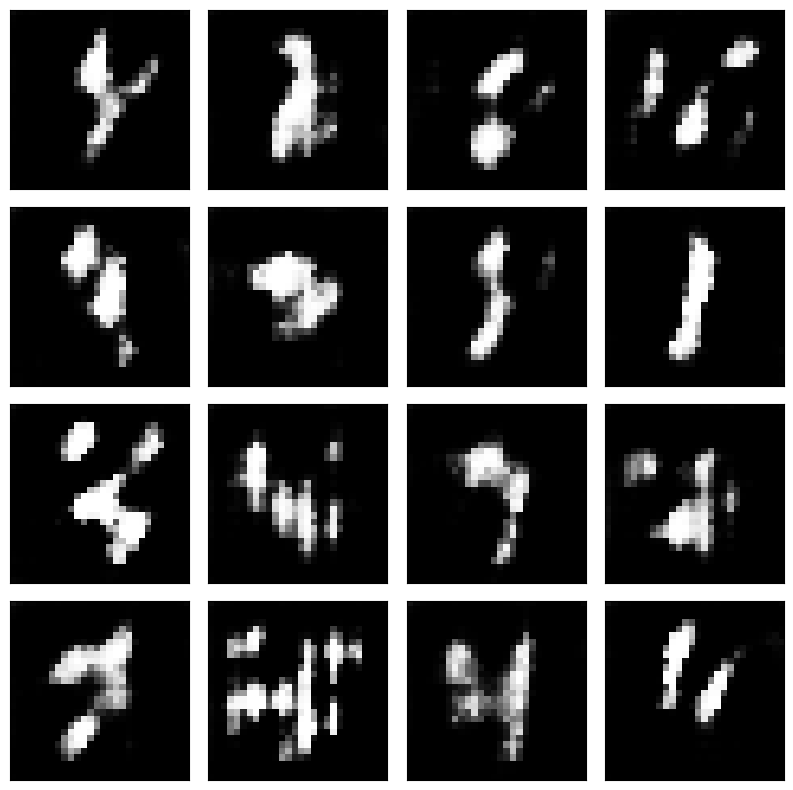




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 5; D_loss=0.6768113970756531; G_loss=2.5578501224517822
(16, 28, 28, 1)
EPOCH # 6
Generated images:


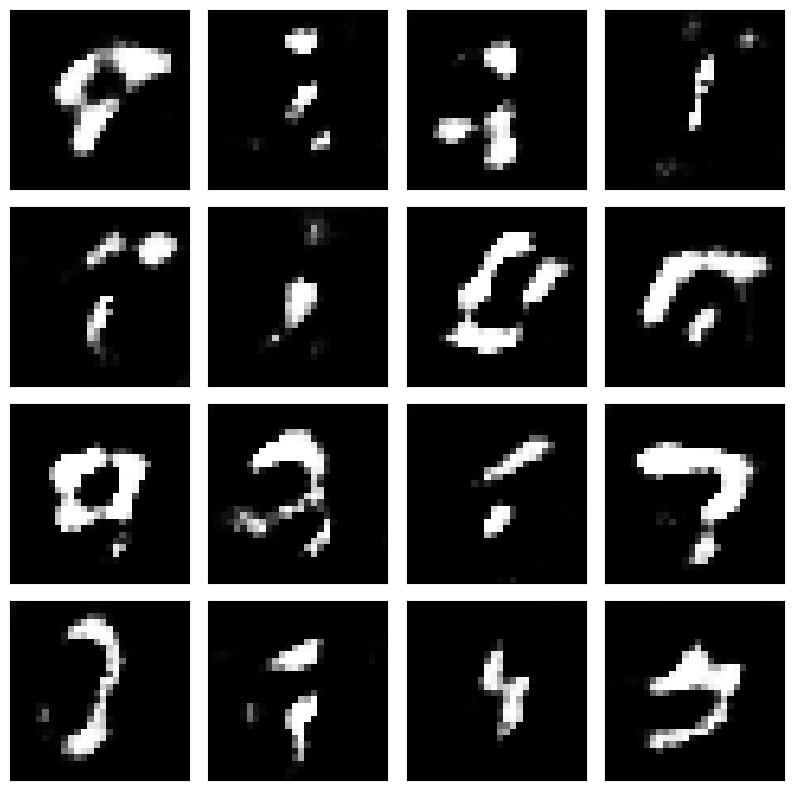




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 6; D_loss=0.6508585810661316; G_loss=2.8200271129608154
(16, 28, 28, 1)
EPOCH # 7
Generated images:


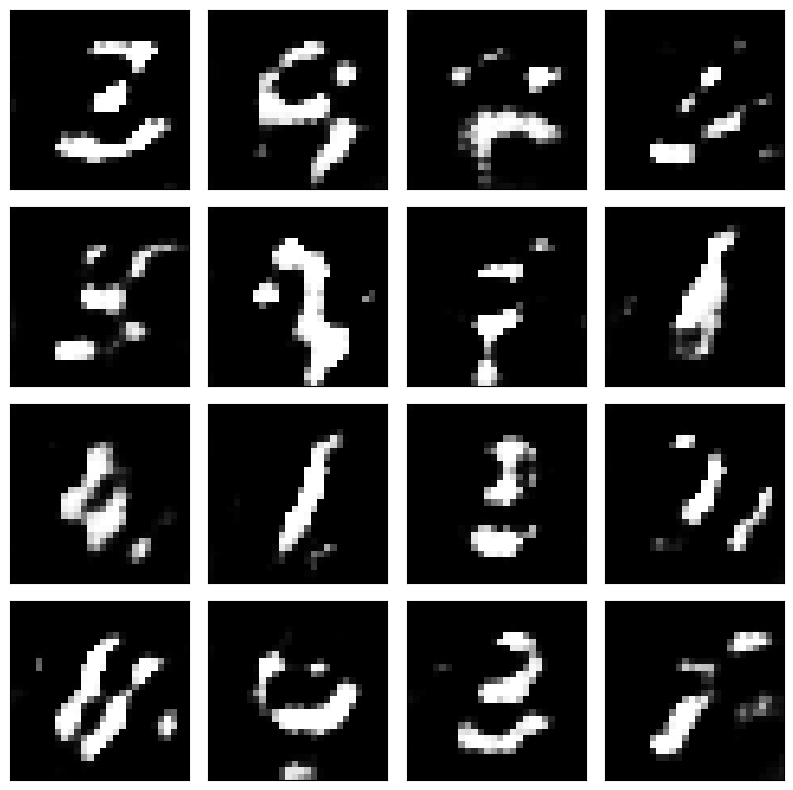




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 7; D_loss=0.7102560997009277; G_loss=2.2719264030456543
(16, 28, 28, 1)
EPOCH # 8
Generated images:


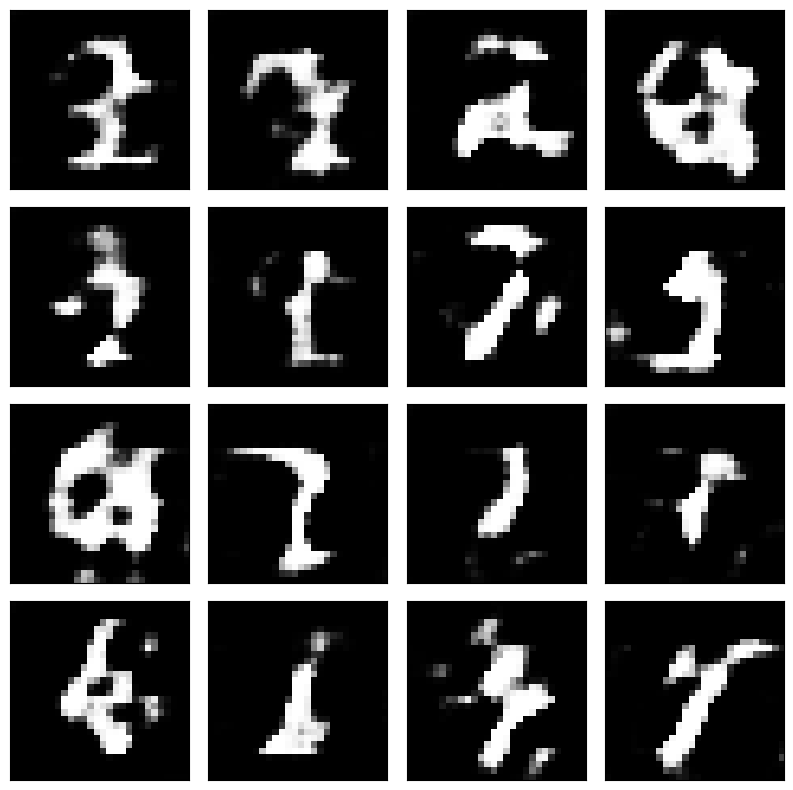




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 8; D_loss=0.6329073905944824; G_loss=2.2159922122955322
(16, 28, 28, 1)
EPOCH # 9
Generated images:


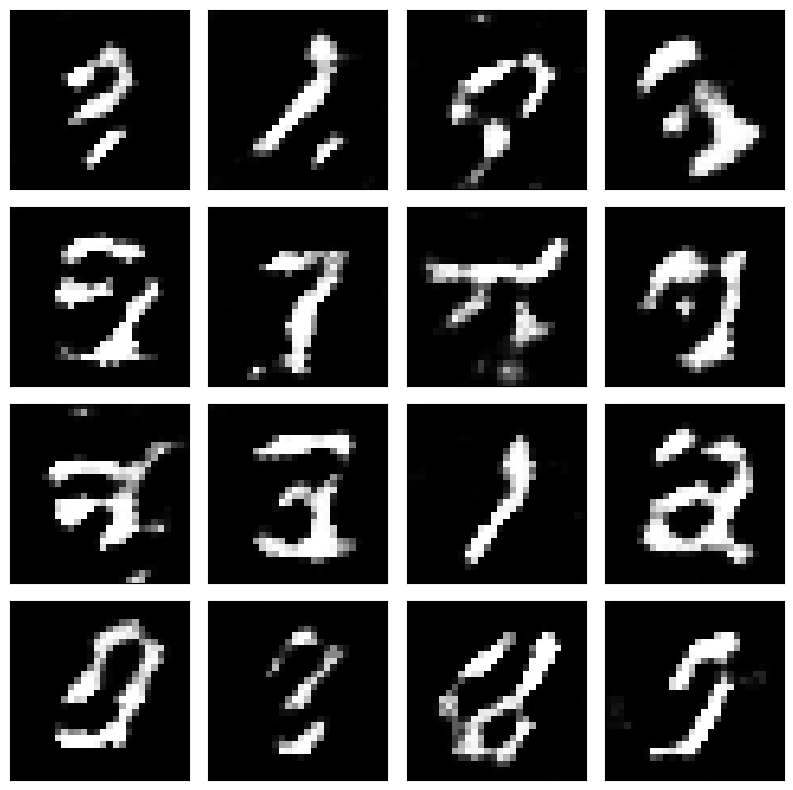




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 9; D_loss=0.8367577791213989; G_loss=1.7122430801391602
(16, 28, 28, 1)
EPOCH # 10
Generated images:


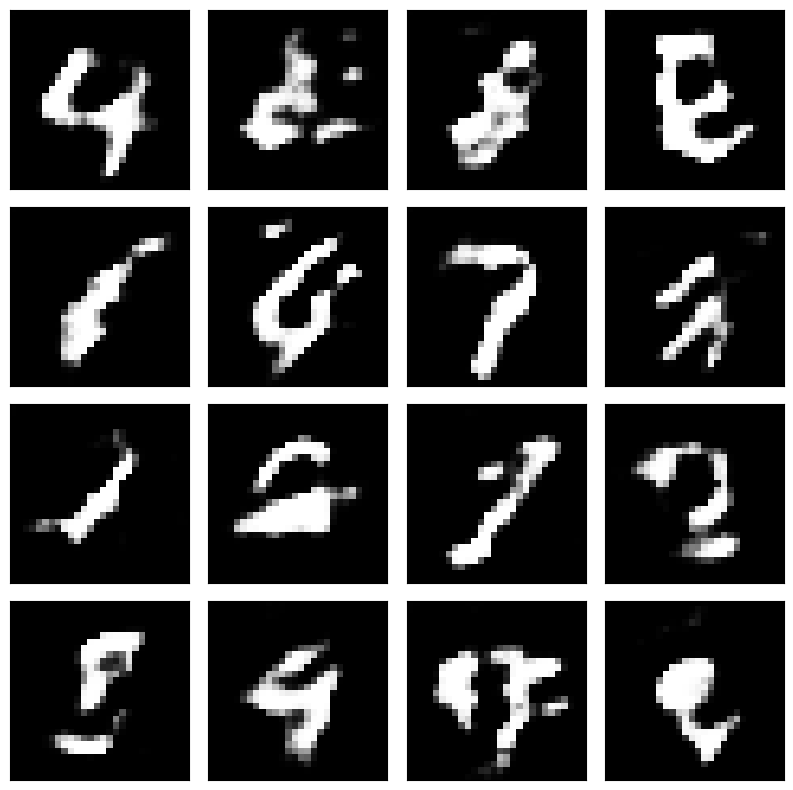




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 10; D_loss=0.8088208436965942; G_loss=1.9759951829910278
(16, 28, 28, 1)
EPOCH # 11
Generated images:


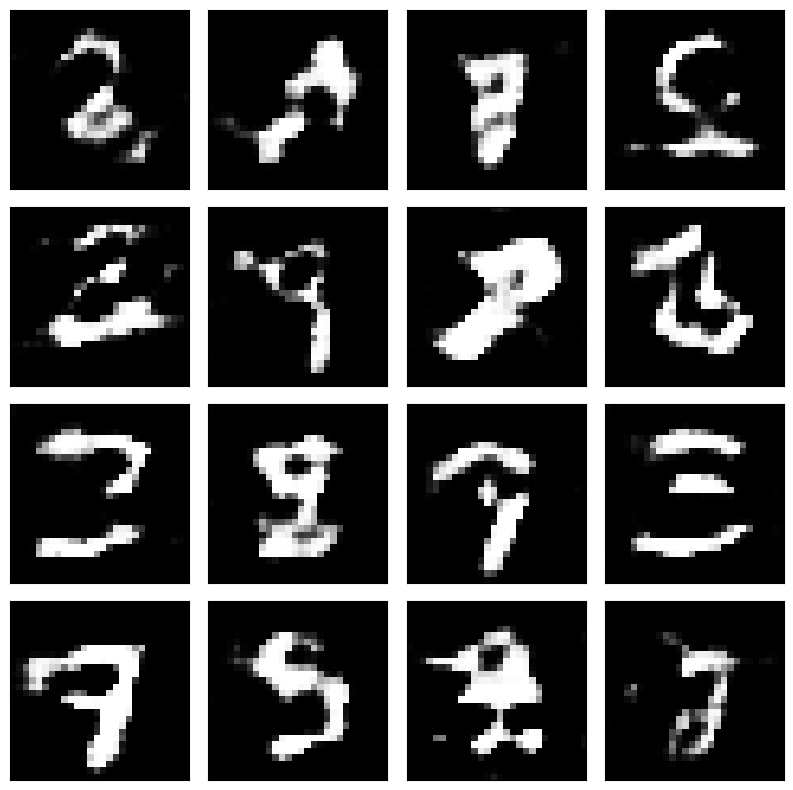




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 11; D_loss=0.8200435638427734; G_loss=1.9852372407913208
(16, 28, 28, 1)
EPOCH # 12
Generated images:


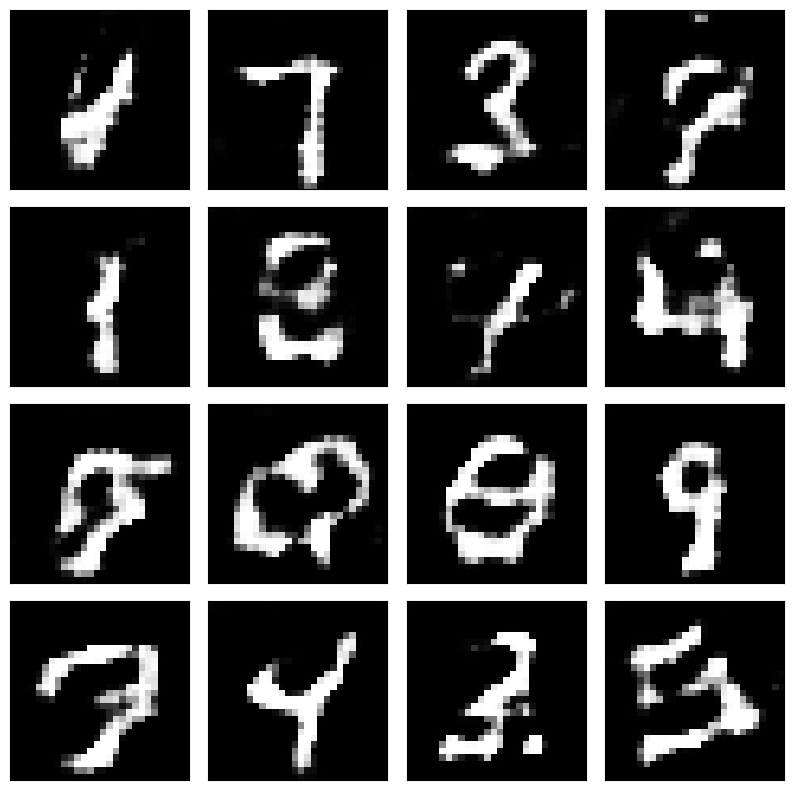




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 12; D_loss=0.5993831753730774; G_loss=2.395822763442993
(16, 28, 28, 1)
EPOCH # 13
Generated images:


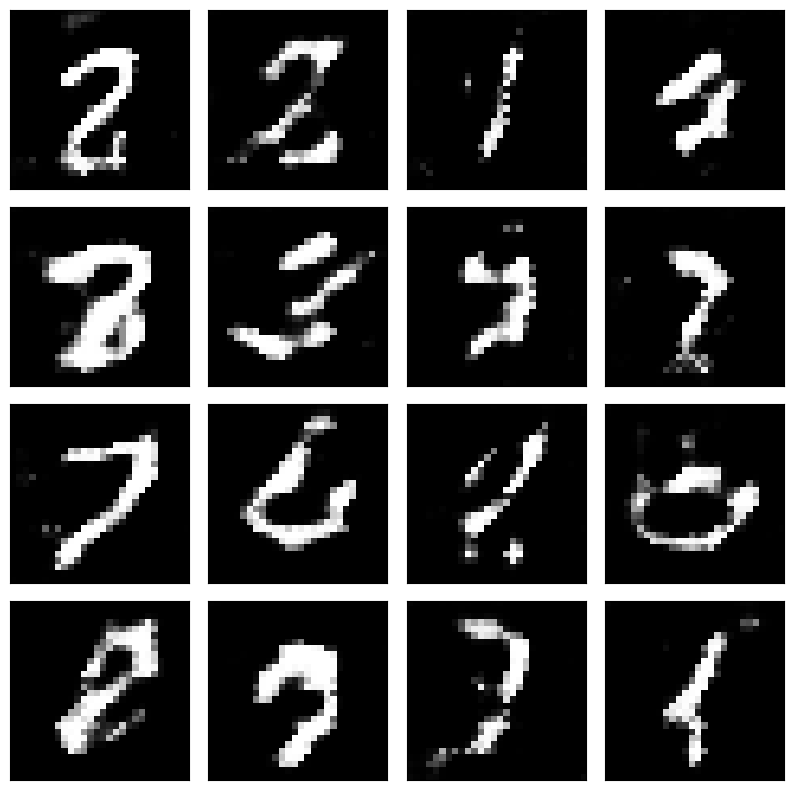




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 13; D_loss=1.0441433191299438; G_loss=1.7447975873947144
(16, 28, 28, 1)
EPOCH # 14
Generated images:


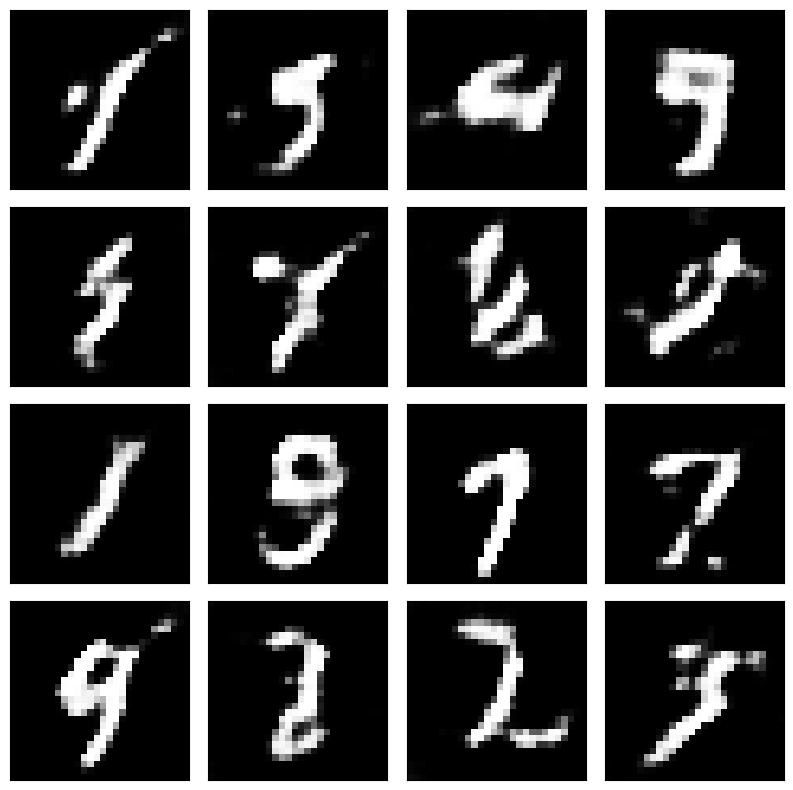




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 14; D_loss=0.824603796005249; G_loss=1.8808507919311523
(16, 28, 28, 1)
EPOCH # 15
Generated images:


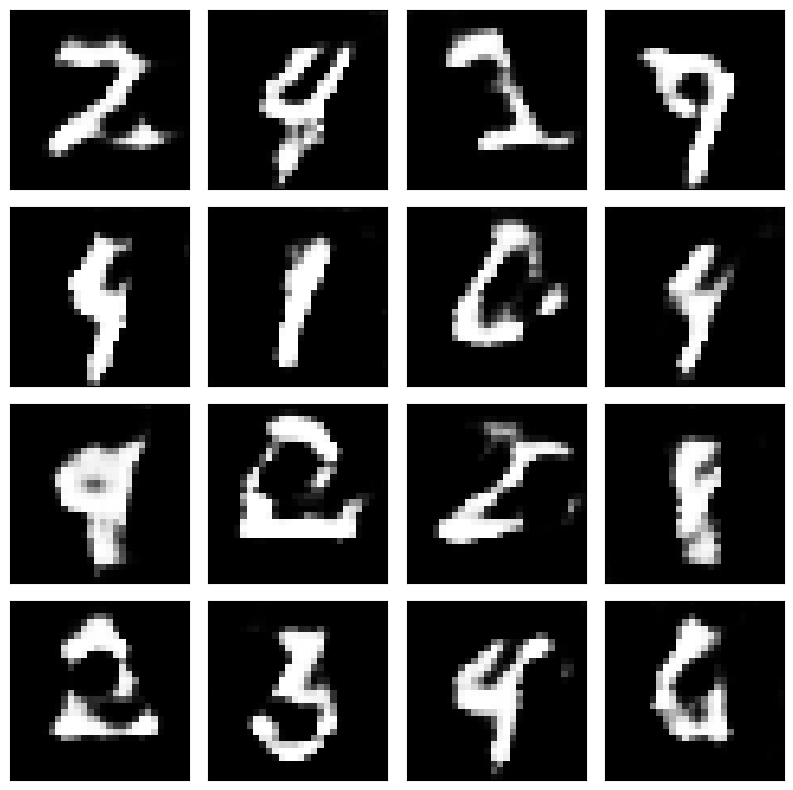




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 15; D_loss=0.8148355484008789; G_loss=2.0970849990844727
(16, 28, 28, 1)
EPOCH # 16
Generated images:


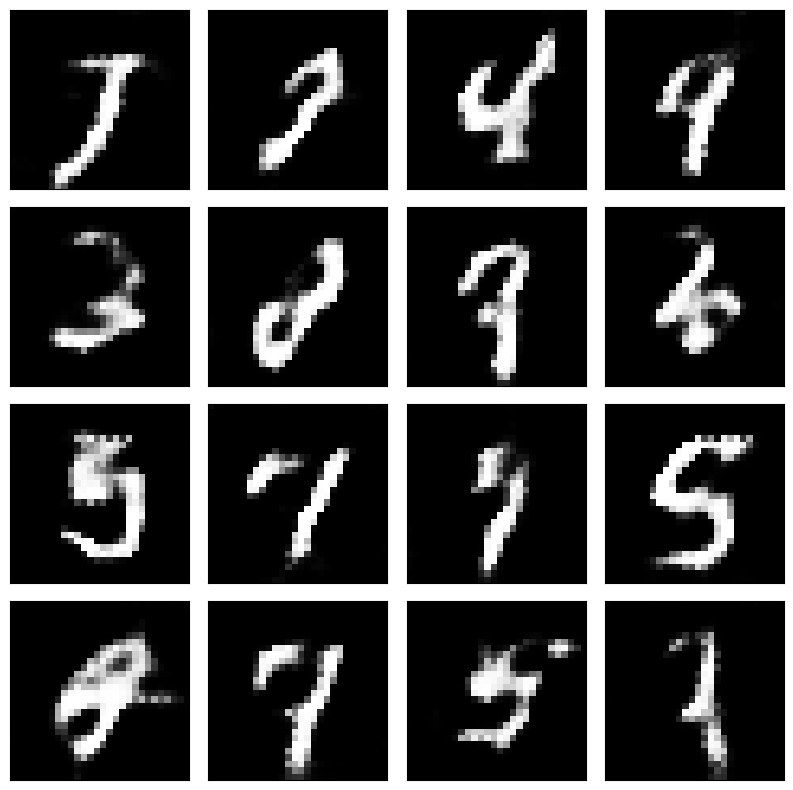




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 16; D_loss=0.8945536613464355; G_loss=1.6935707330703735
(16, 28, 28, 1)
EPOCH # 17
Generated images:


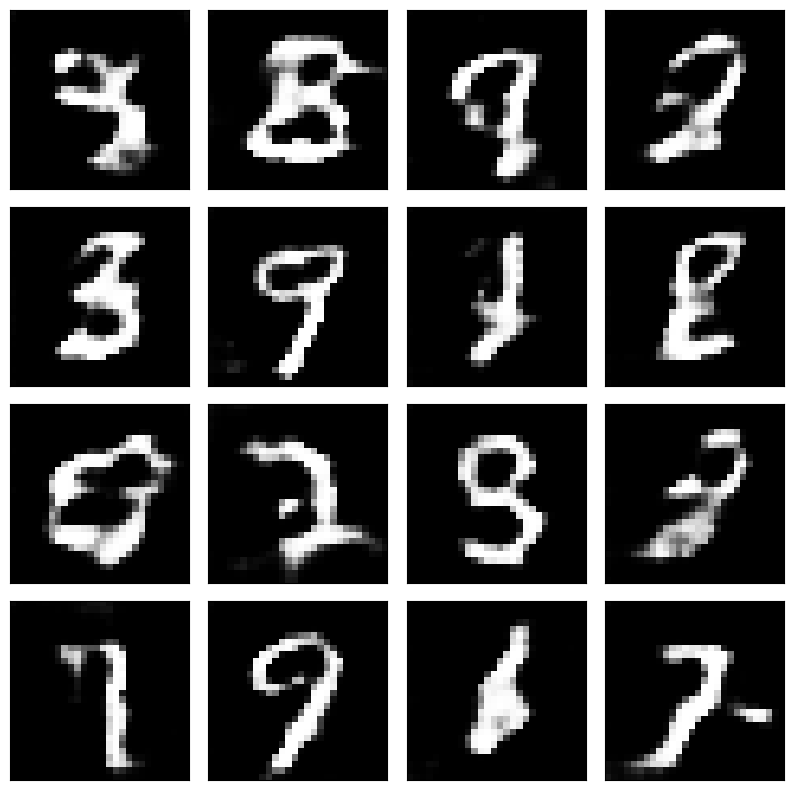




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 17; D_loss=0.8127750754356384; G_loss=1.611469030380249
(16, 28, 28, 1)
EPOCH # 18
Generated images:


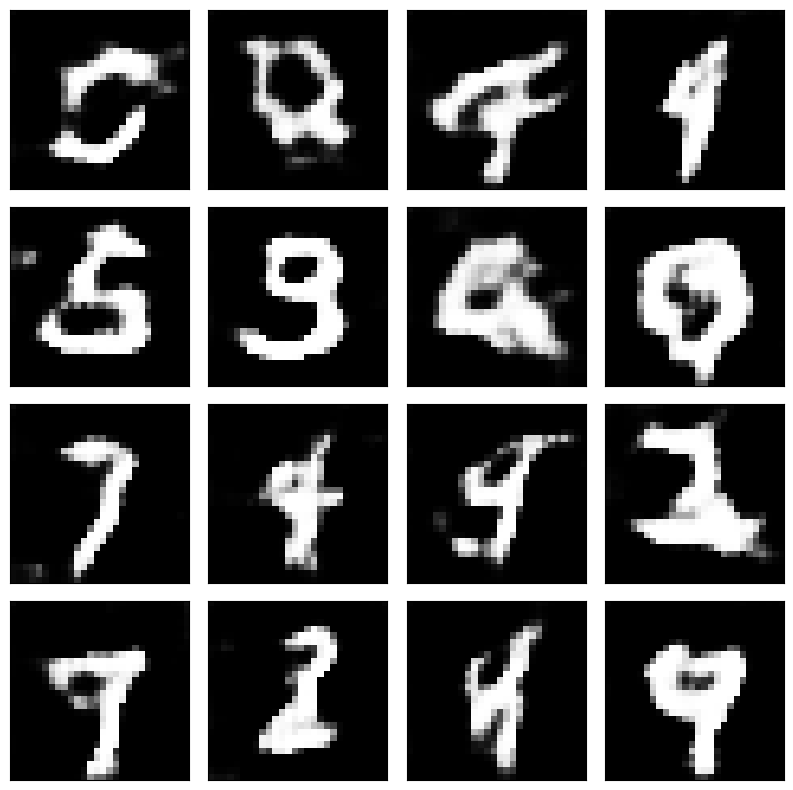




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 18; D_loss=0.8384984731674194; G_loss=1.9881919622421265
(16, 28, 28, 1)
EPOCH # 19
Generated images:


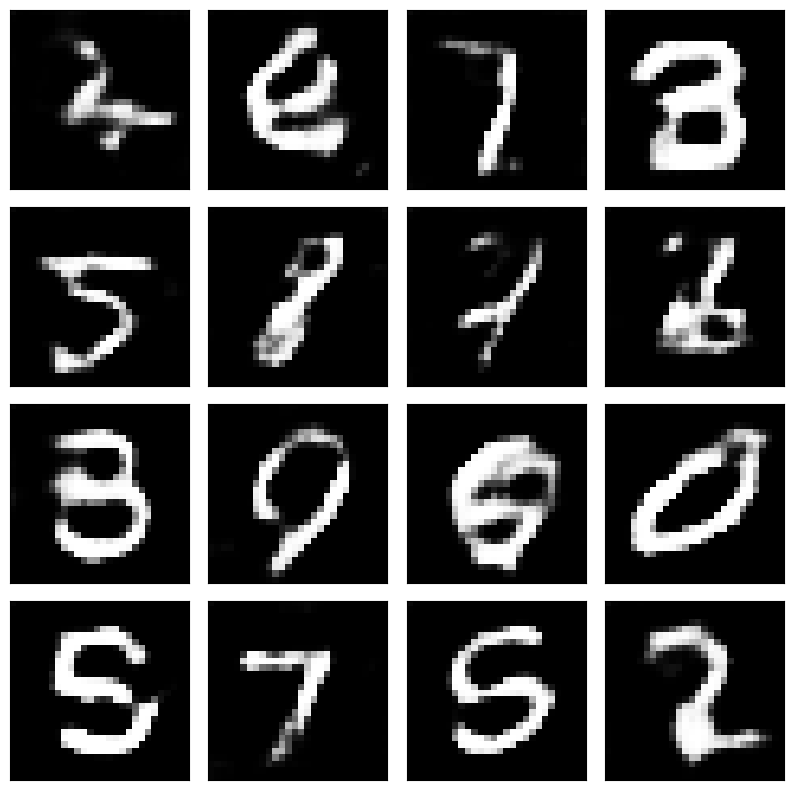




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 19; D_loss=0.7686144709587097; G_loss=2.025062322616577
(16, 28, 28, 1)
EPOCH # 20
Generated images:


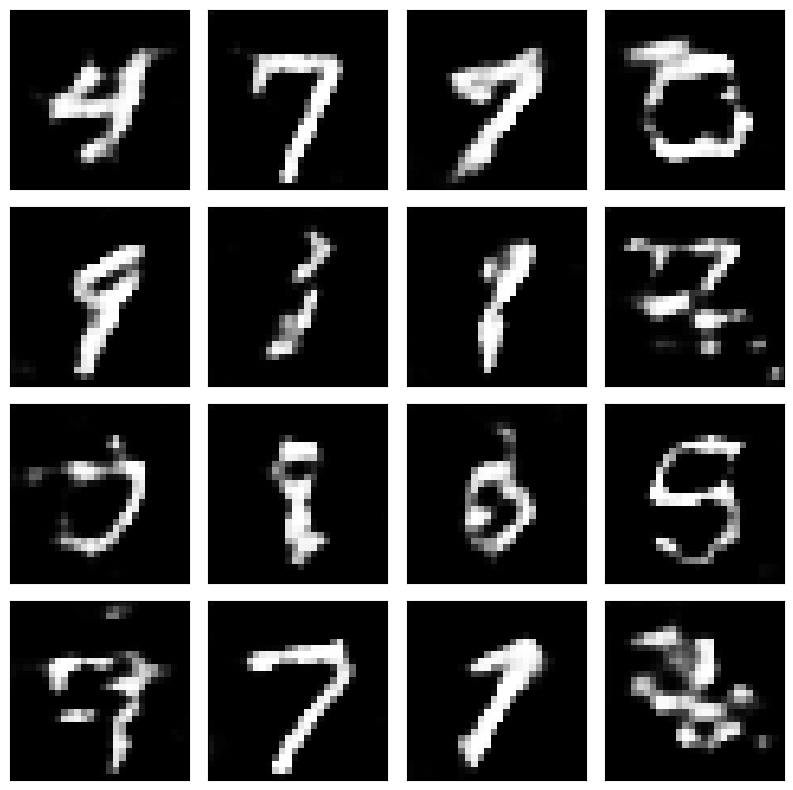




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 20; D_loss=1.0837103128433228; G_loss=1.7578859329223633
(16, 28, 28, 1)
EPOCH # 21
Generated images:


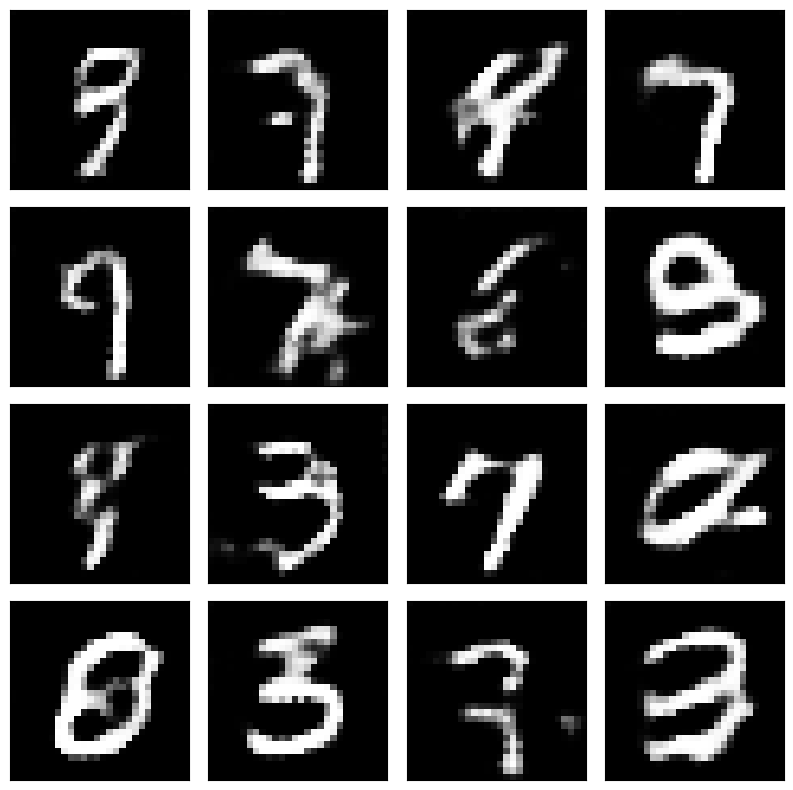




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 21; D_loss=0.5635767579078674; G_loss=2.3732852935791016
(16, 28, 28, 1)
EPOCH # 22
Generated images:


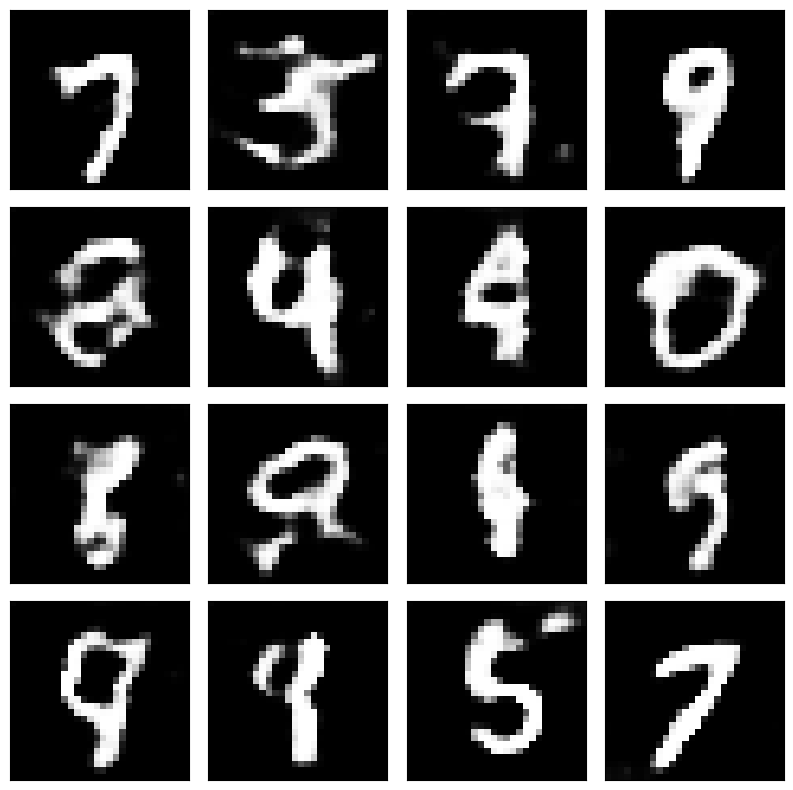




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 22; D_loss=0.8996371626853943; G_loss=1.825751543045044
(16, 28, 28, 1)
EPOCH # 23
Generated images:


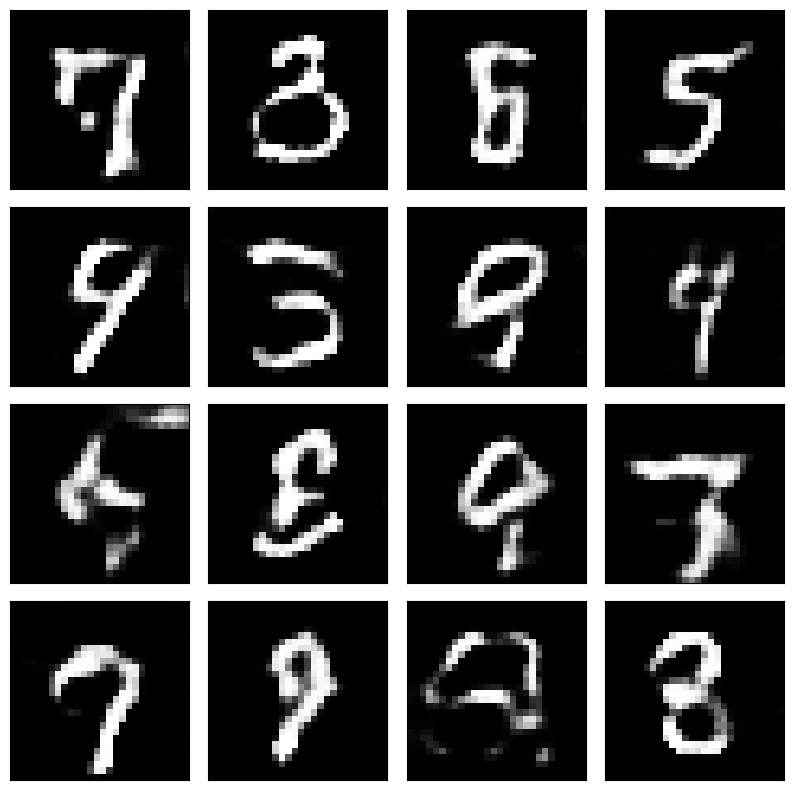




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 23; D_loss=0.8270139694213867; G_loss=1.879414439201355
(16, 28, 28, 1)
EPOCH # 24
Generated images:


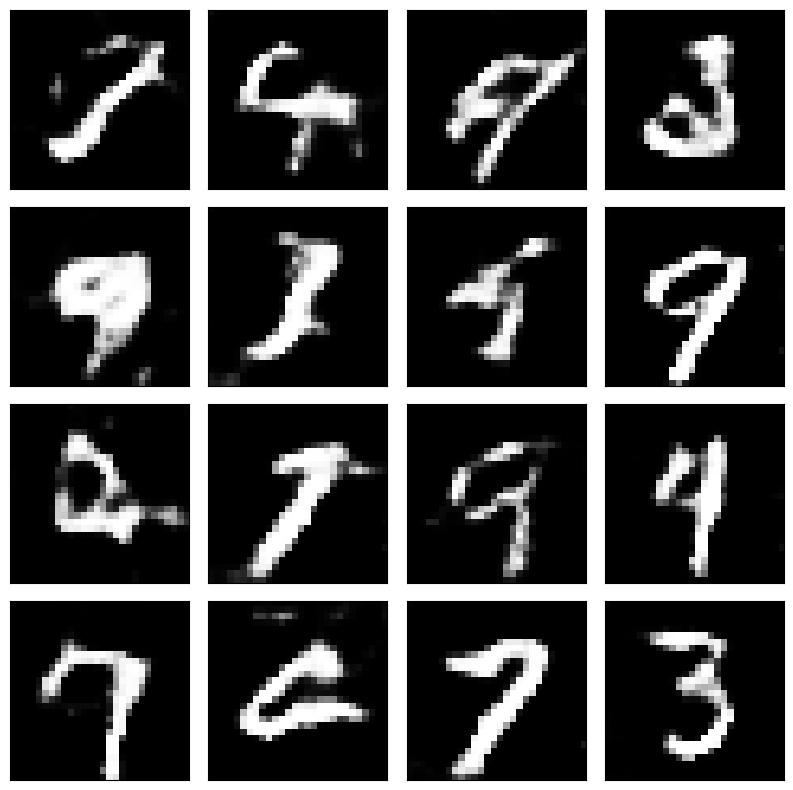




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 24; D_loss=0.7965723276138306; G_loss=1.7648770809173584
(16, 28, 28, 1)
EPOCH # 25
Generated images:


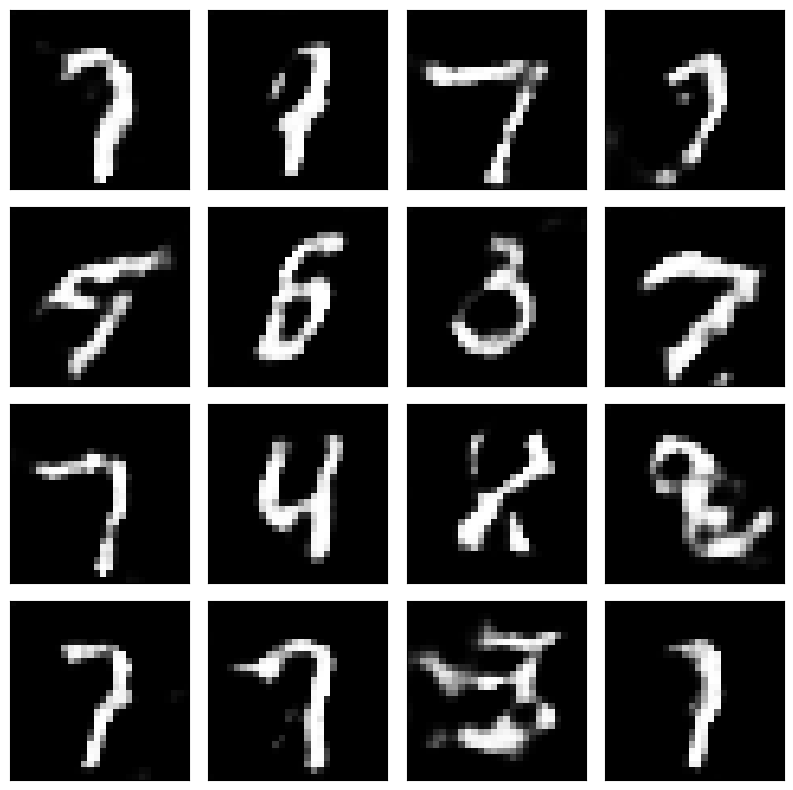




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 25; D_loss=0.7600975632667542; G_loss=2.0572073459625244
(16, 28, 28, 1)
EPOCH # 26
Generated images:


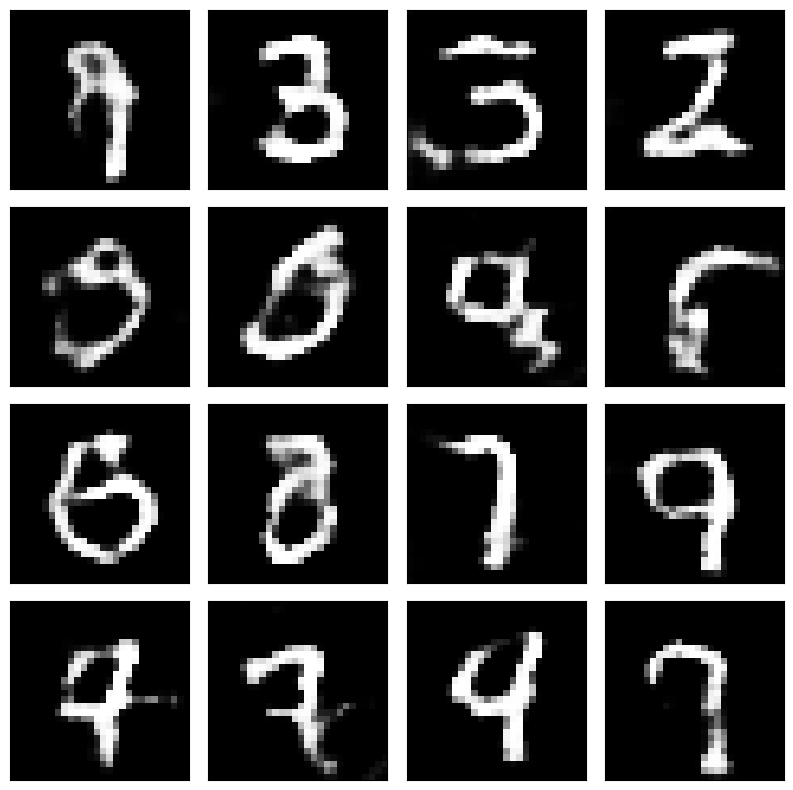




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 26; D_loss=0.8850781321525574; G_loss=1.6856282949447632
(16, 28, 28, 1)
EPOCH # 27
Generated images:


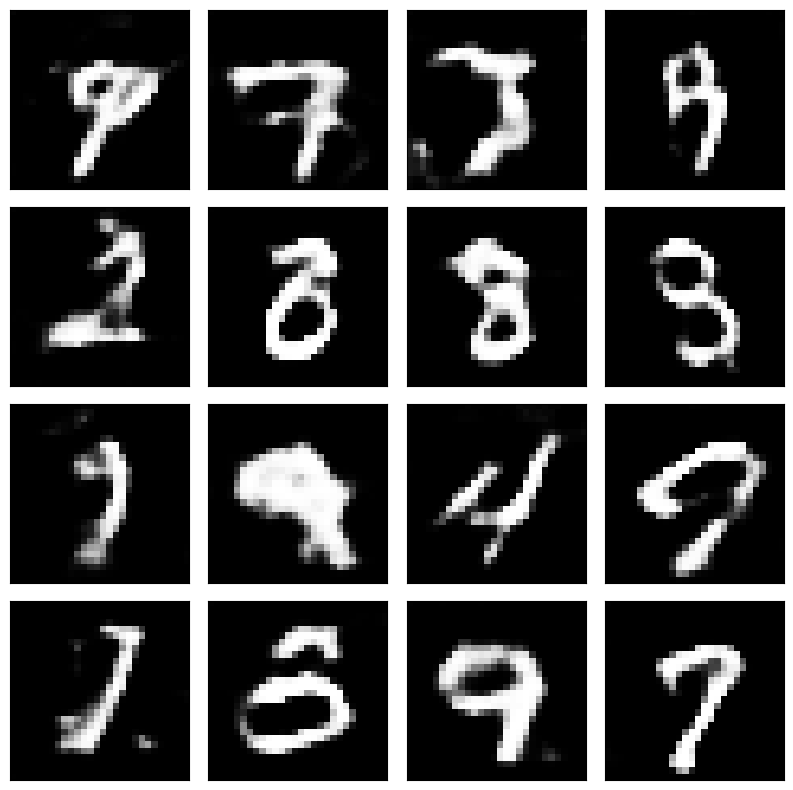




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 27; D_loss=0.8868720531463623; G_loss=1.881011724472046
(16, 28, 28, 1)
EPOCH # 28
Generated images:


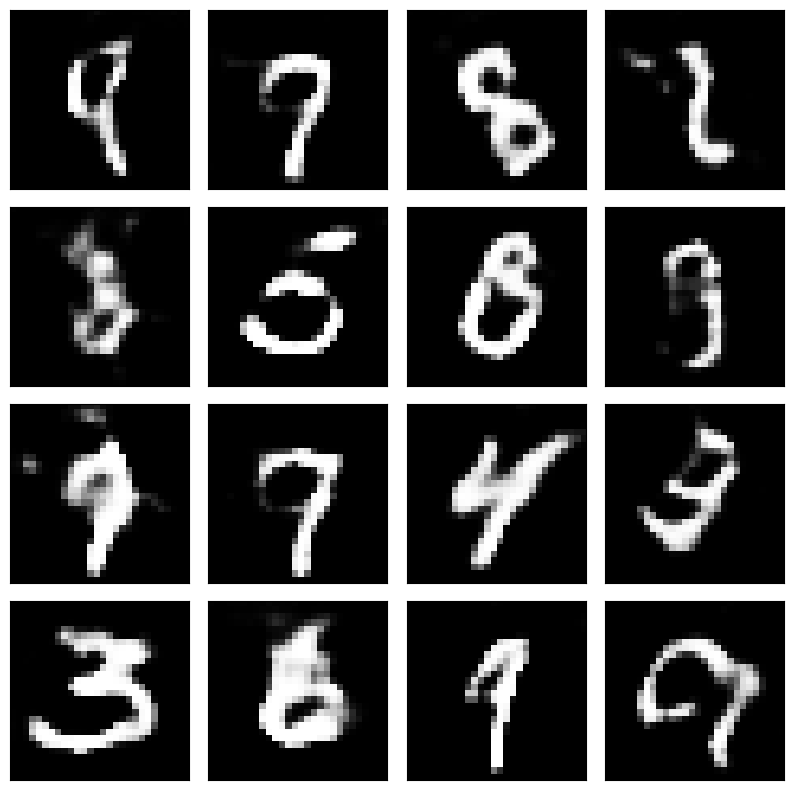




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 28; D_loss=0.8083263635635376; G_loss=2.074401378631592
(16, 28, 28, 1)
EPOCH # 29
Generated images:


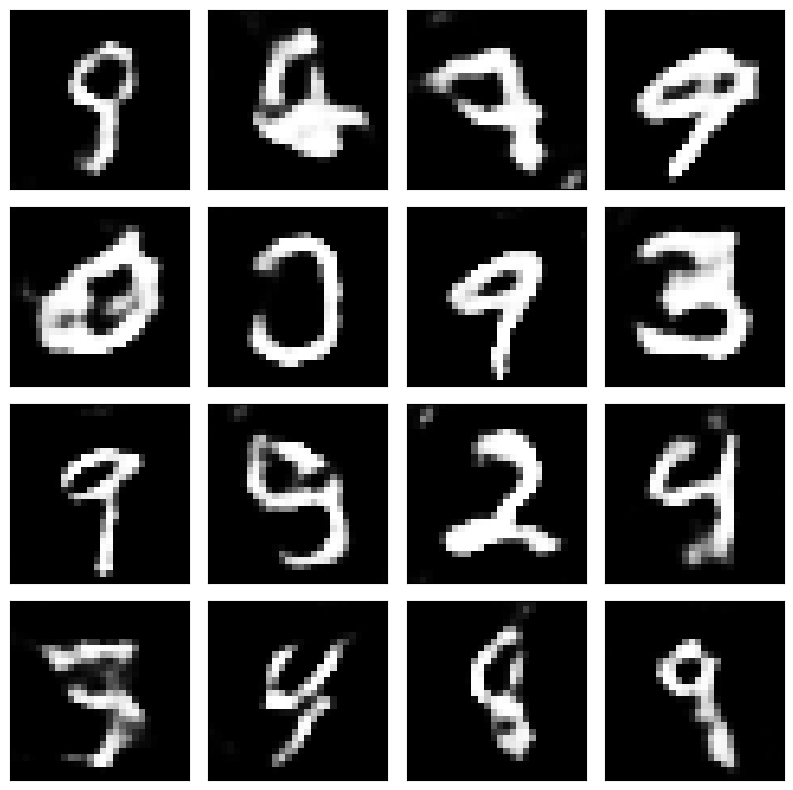




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 29; D_loss=0.8359165191650391; G_loss=1.835836410522461
(16, 28, 28, 1)
EPOCH # 30
Generated images:


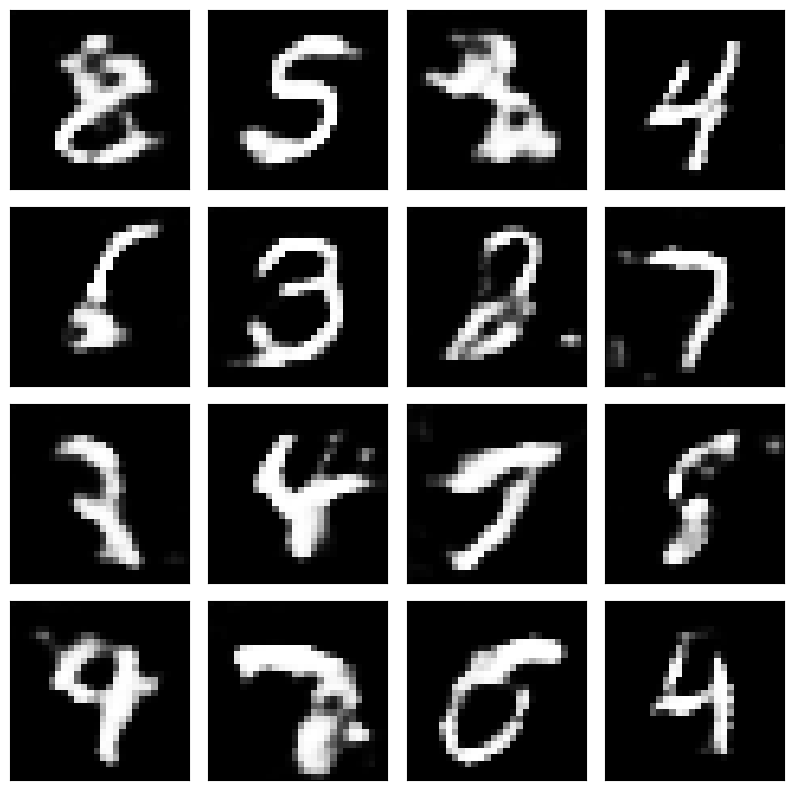




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 30; D_loss=0.7177954912185669; G_loss=2.1887569427490234
(16, 28, 28, 1)
EPOCH # 31
Generated images:


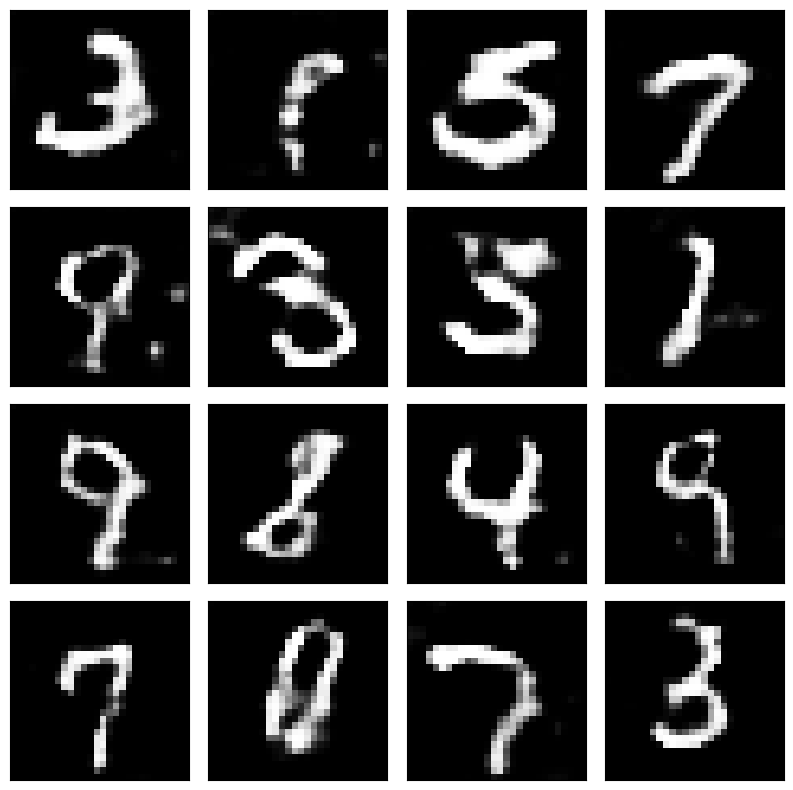




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 31; D_loss=0.9855294227600098; G_loss=1.7363176345825195
(16, 28, 28, 1)
EPOCH # 32
Generated images:


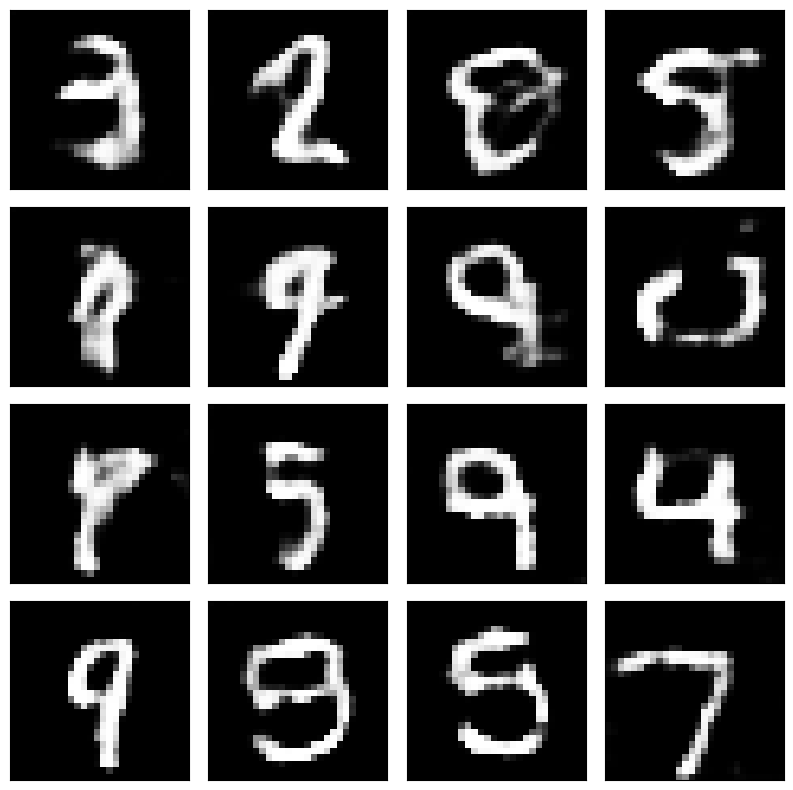




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 32; D_loss=0.7571170926094055; G_loss=1.7732421159744263
(16, 28, 28, 1)
EPOCH # 33
Generated images:


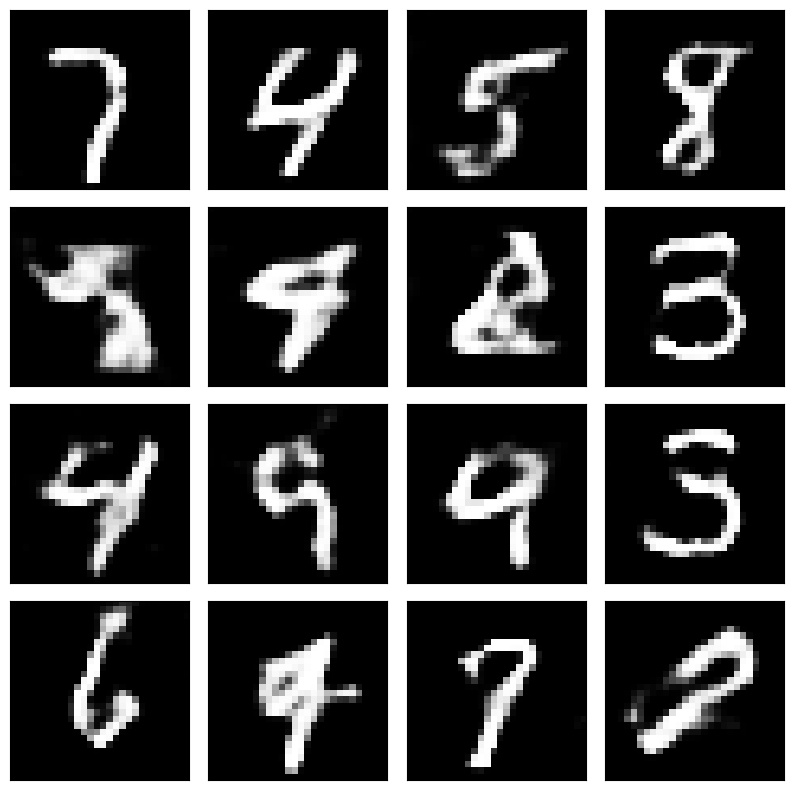




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 33; D_loss=0.764725923538208; G_loss=1.888767957687378
(16, 28, 28, 1)
EPOCH # 34
Generated images:


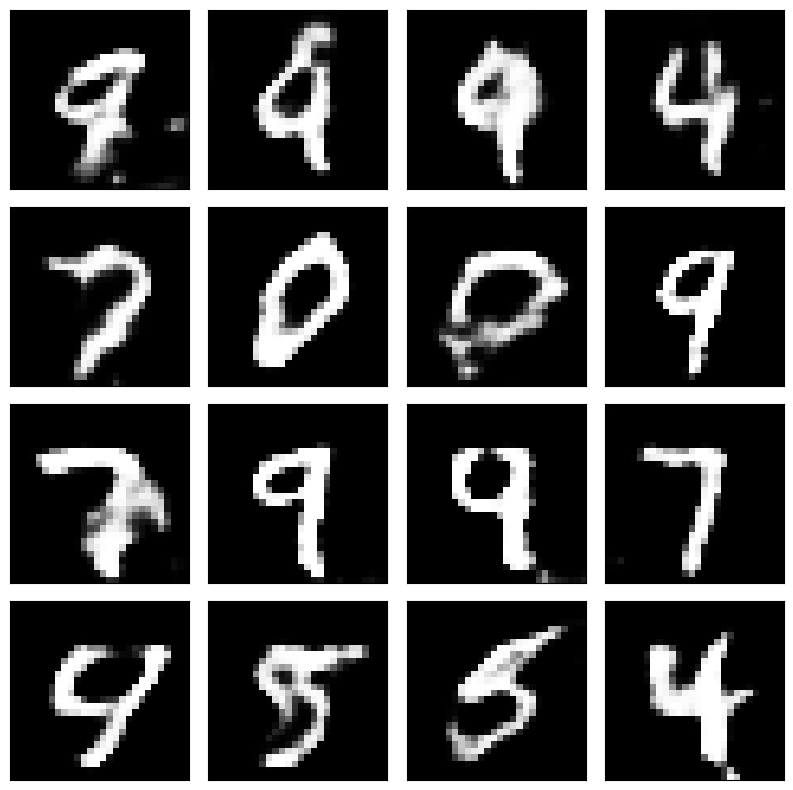




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 34; D_loss=0.9050415754318237; G_loss=1.7801766395568848
(16, 28, 28, 1)
EPOCH # 35
Generated images:


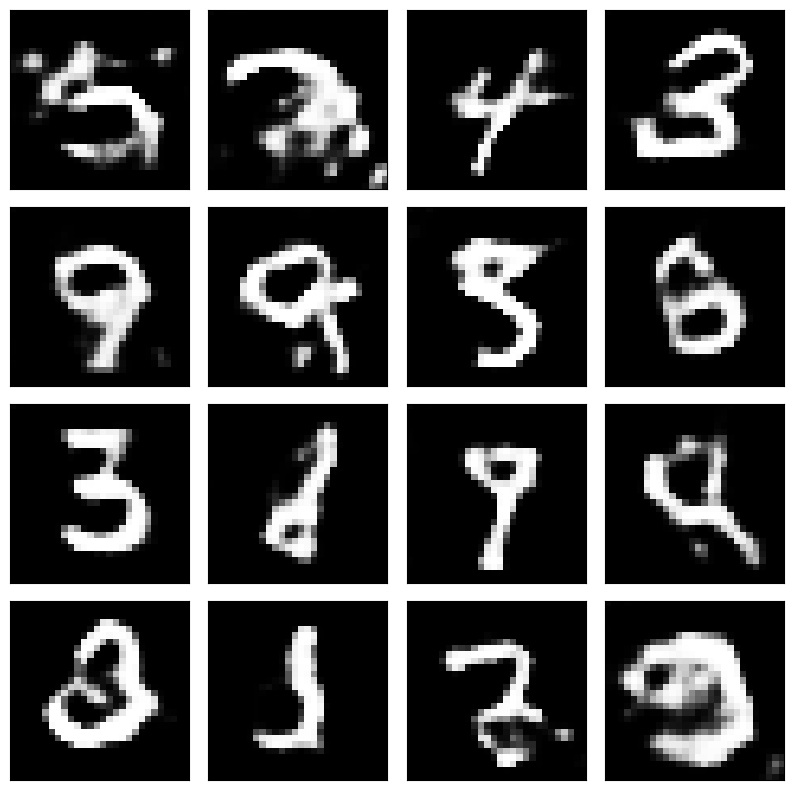




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 35; D_loss=0.9415255188941956; G_loss=1.6608494520187378
(16, 28, 28, 1)
EPOCH # 36
Generated images:


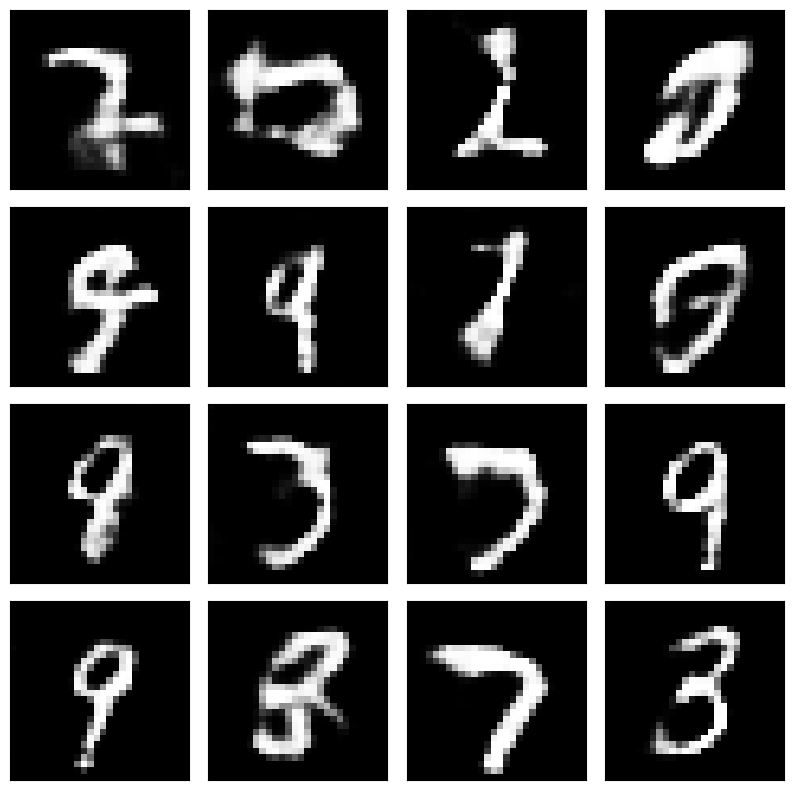




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 36; D_loss=0.945472002029419; G_loss=1.7162843942642212
(16, 28, 28, 1)
EPOCH # 37
Generated images:


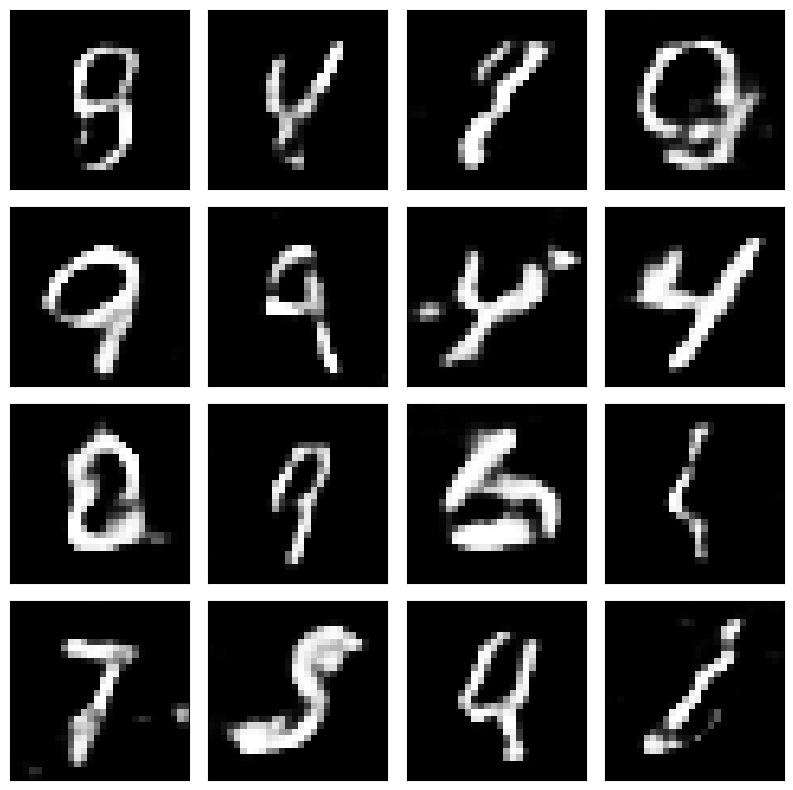




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 37; D_loss=0.8829644918441772; G_loss=1.6371046304702759
(16, 28, 28, 1)
EPOCH # 38
Generated images:


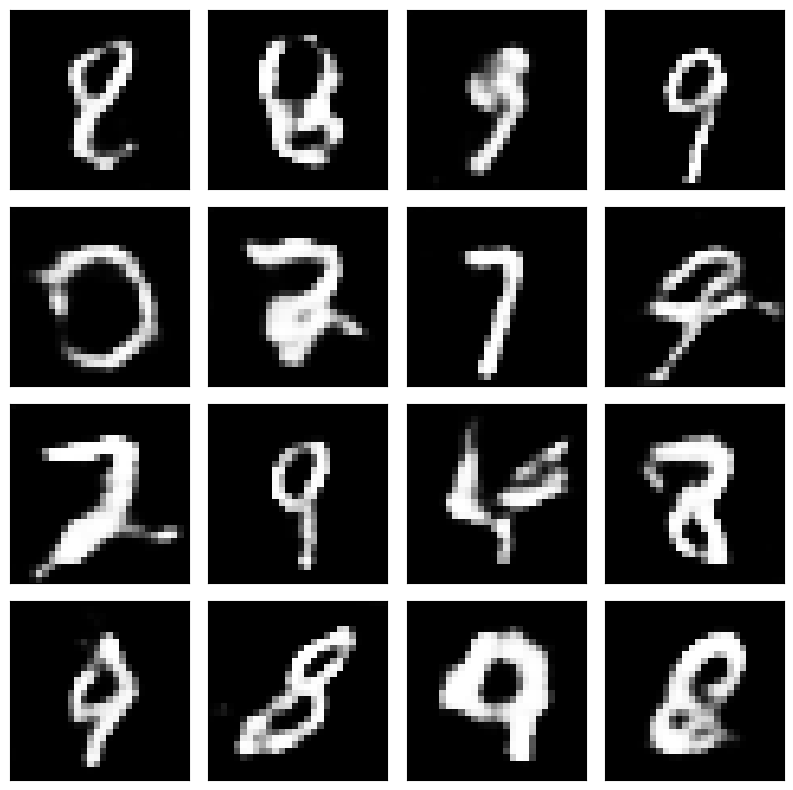




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 38; D_loss=0.878016471862793; G_loss=1.566129446029663
(16, 28, 28, 1)
EPOCH # 39
Generated images:


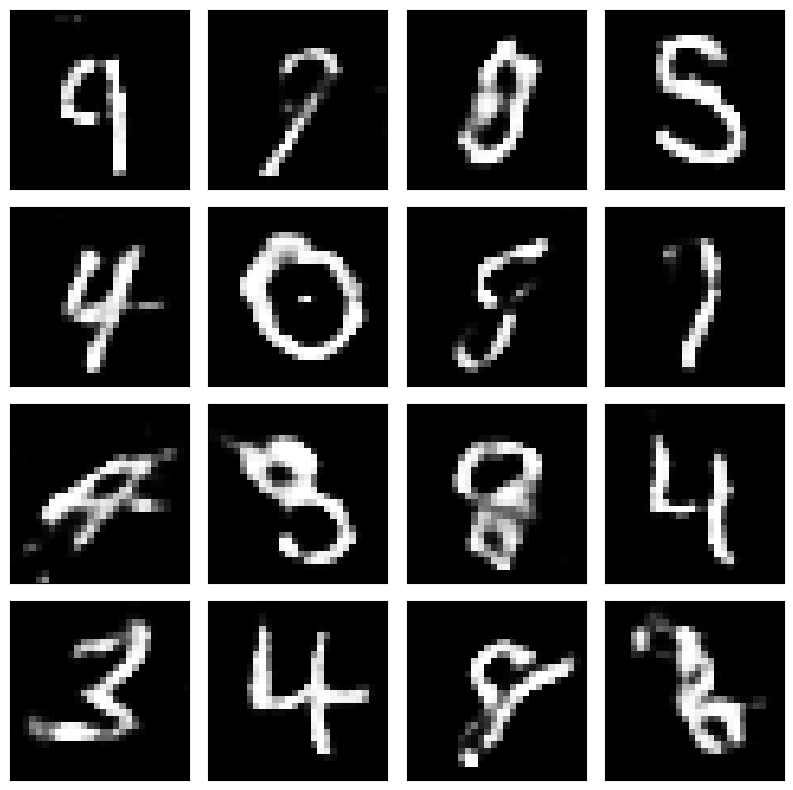




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 39; D_loss=0.9348445534706116; G_loss=1.4943513870239258
(16, 28, 28, 1)
EPOCH # 40
Generated images:


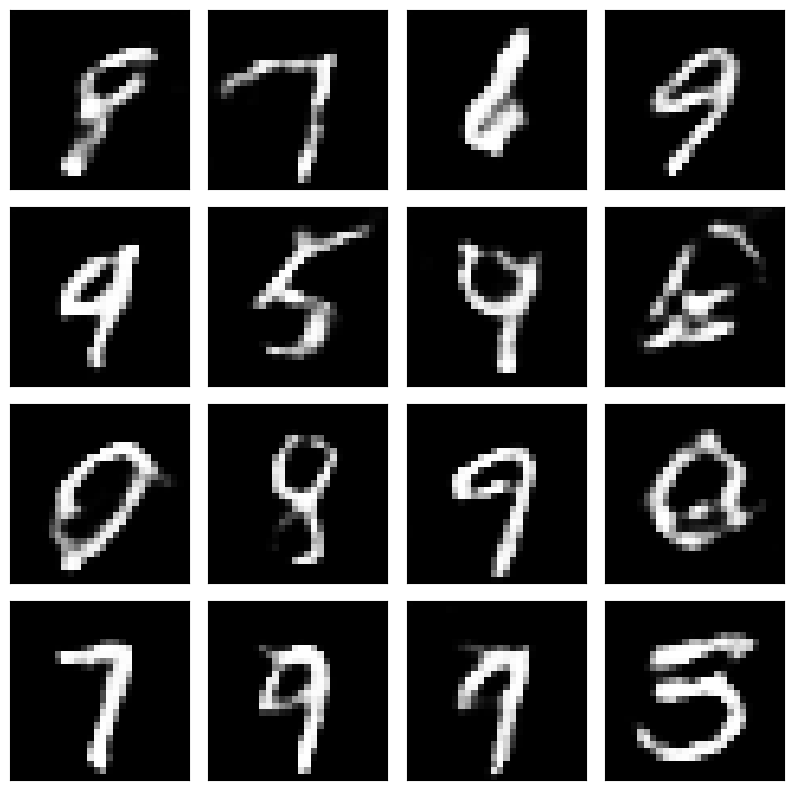




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 40; D_loss=0.8845264911651611; G_loss=1.6832947731018066
(16, 28, 28, 1)
EPOCH # 41
Generated images:


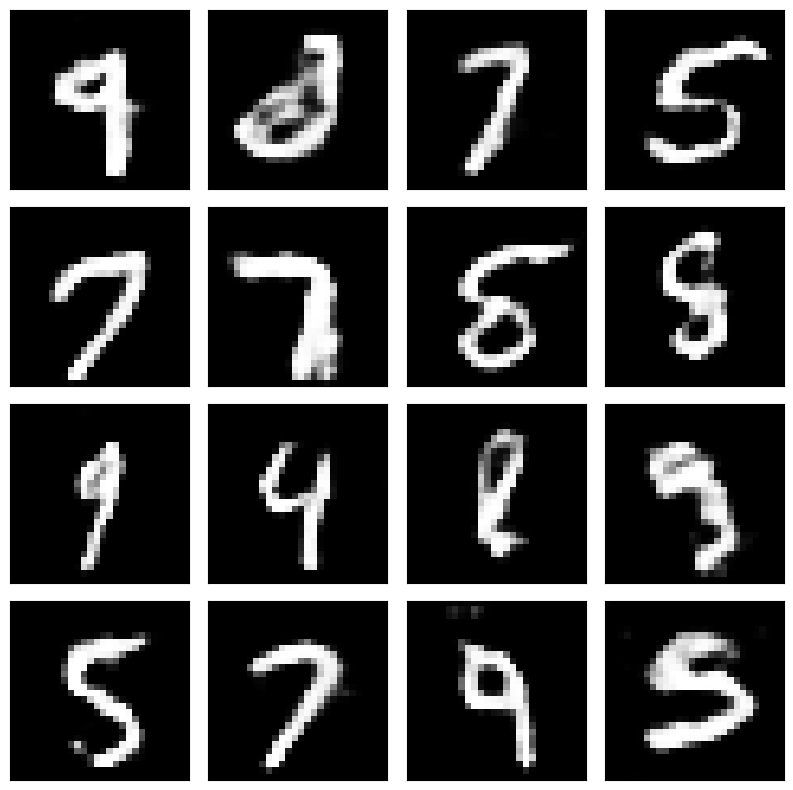




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 41; D_loss=0.9277560114860535; G_loss=1.722076416015625
(16, 28, 28, 1)
EPOCH # 42
Generated images:


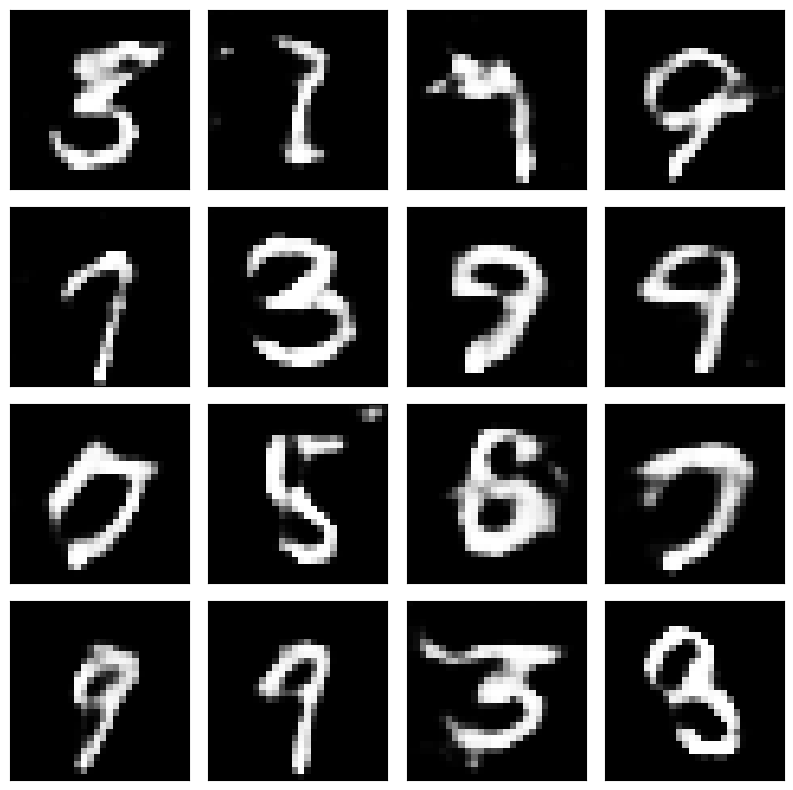




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 42; D_loss=0.8464138507843018; G_loss=1.7805496454238892
(16, 28, 28, 1)
EPOCH # 43
Generated images:


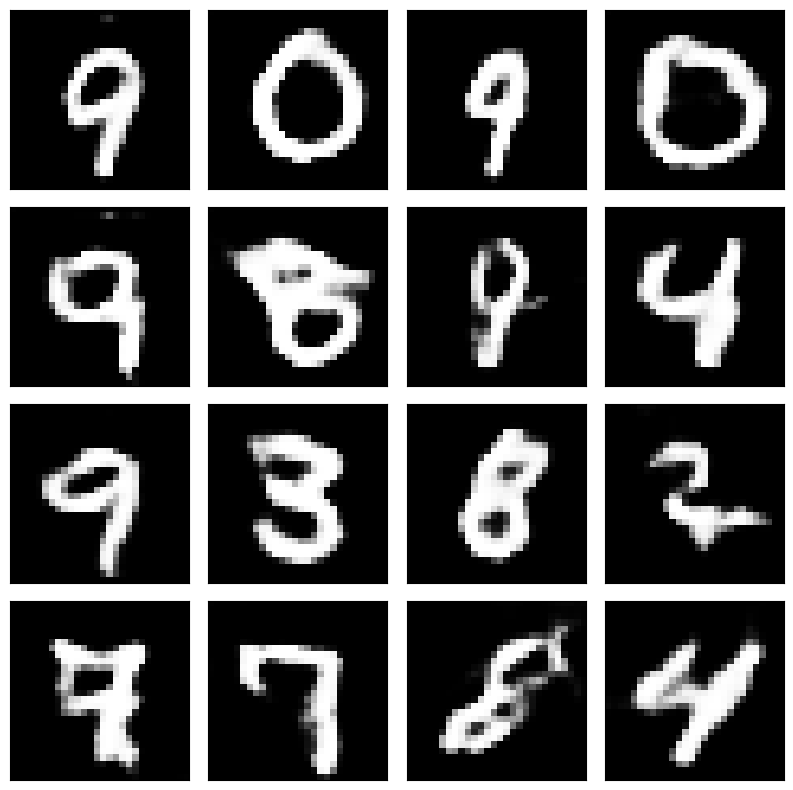




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 43; D_loss=0.8921887874603271; G_loss=1.8675806522369385
(16, 28, 28, 1)
EPOCH # 44
Generated images:


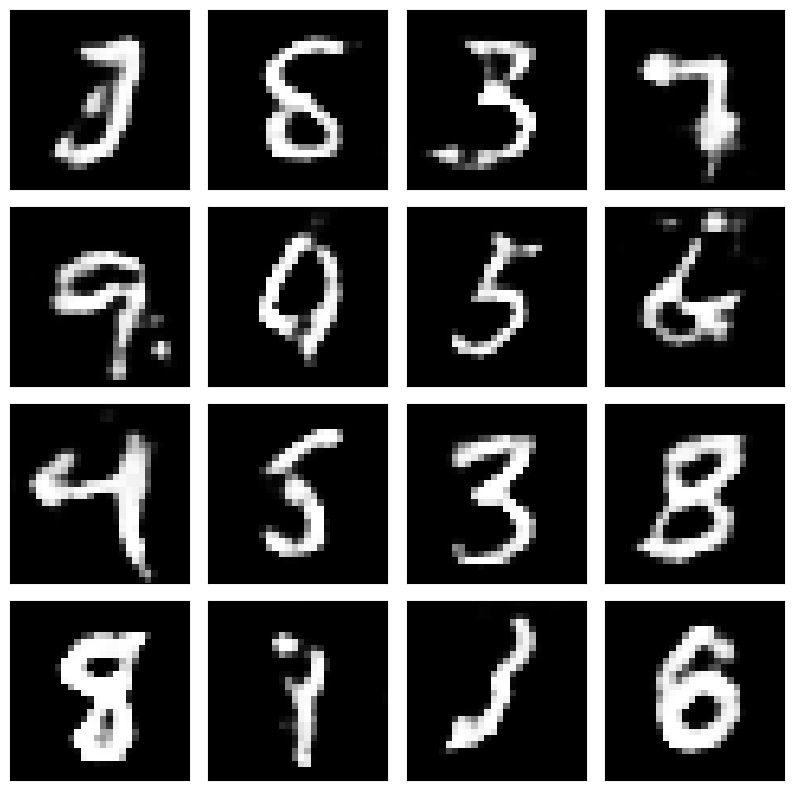




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 44; D_loss=0.9587463140487671; G_loss=1.533243179321289
(16, 28, 28, 1)
EPOCH # 45
Generated images:


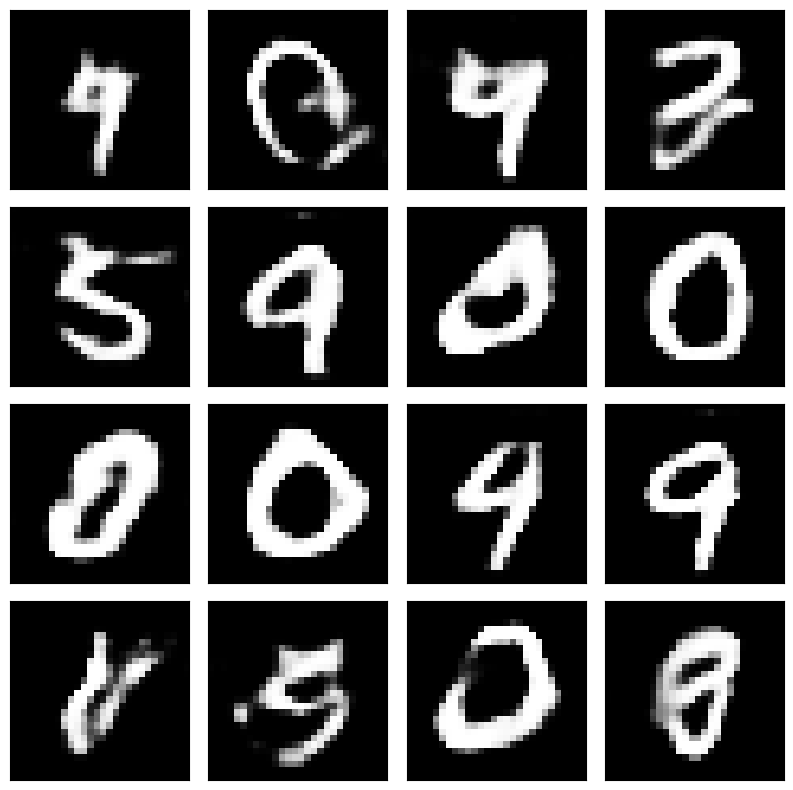




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 45; D_loss=0.8788498044013977; G_loss=1.8158900737762451
(16, 28, 28, 1)
EPOCH # 46
Generated images:


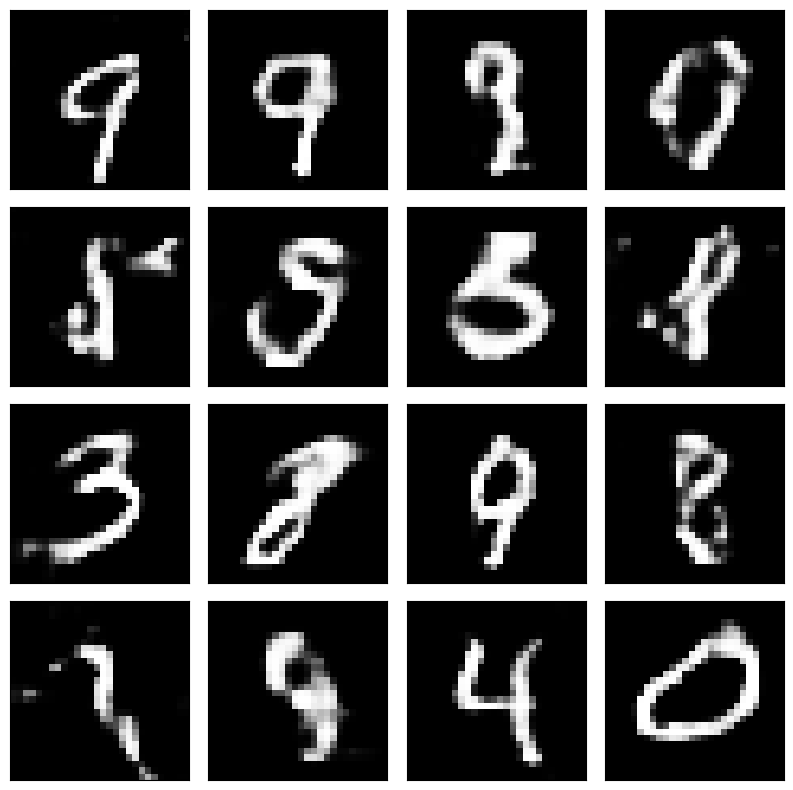




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 46; D_loss=0.9431957602500916; G_loss=1.6732044219970703
(16, 28, 28, 1)
EPOCH # 47
Generated images:


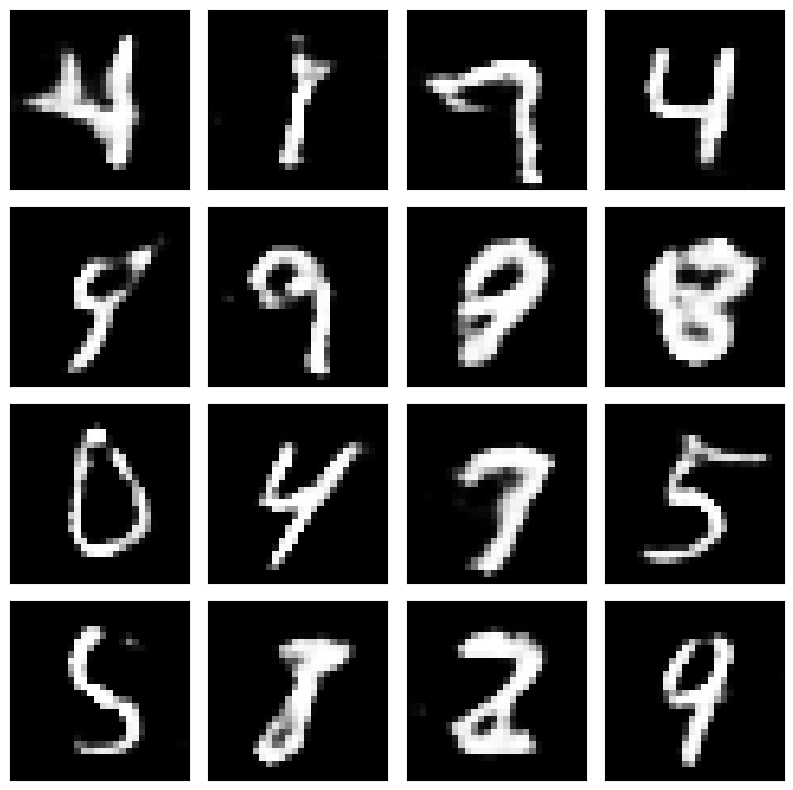




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 47; D_loss=0.9417349100112915; G_loss=1.4256073236465454
(16, 28, 28, 1)
EPOCH # 48
Generated images:


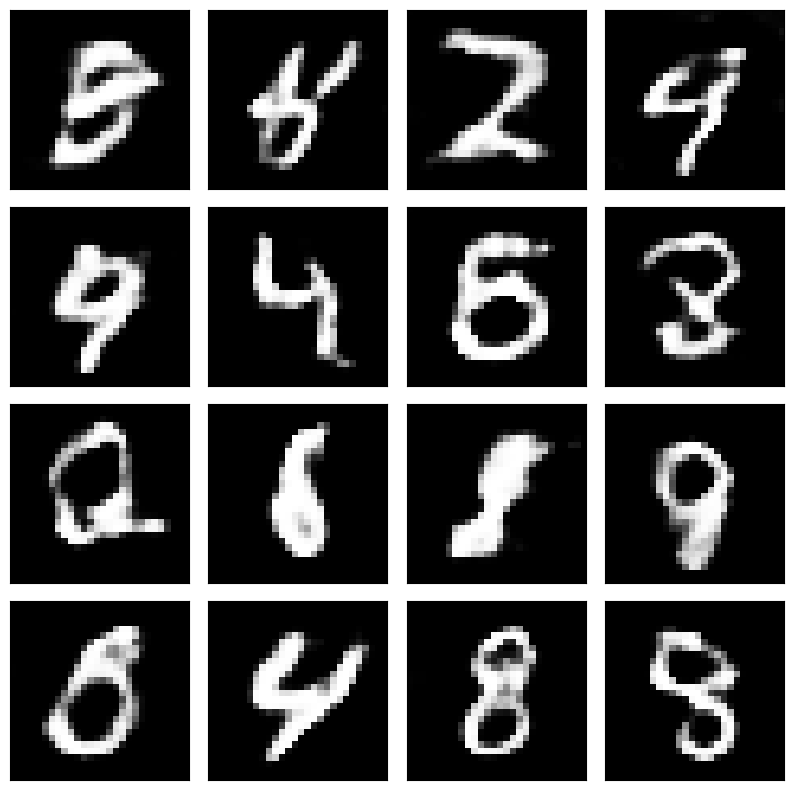




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 48; D_loss=0.9000176191329956; G_loss=1.3618741035461426
(16, 28, 28, 1)
EPOCH # 49
Generated images:


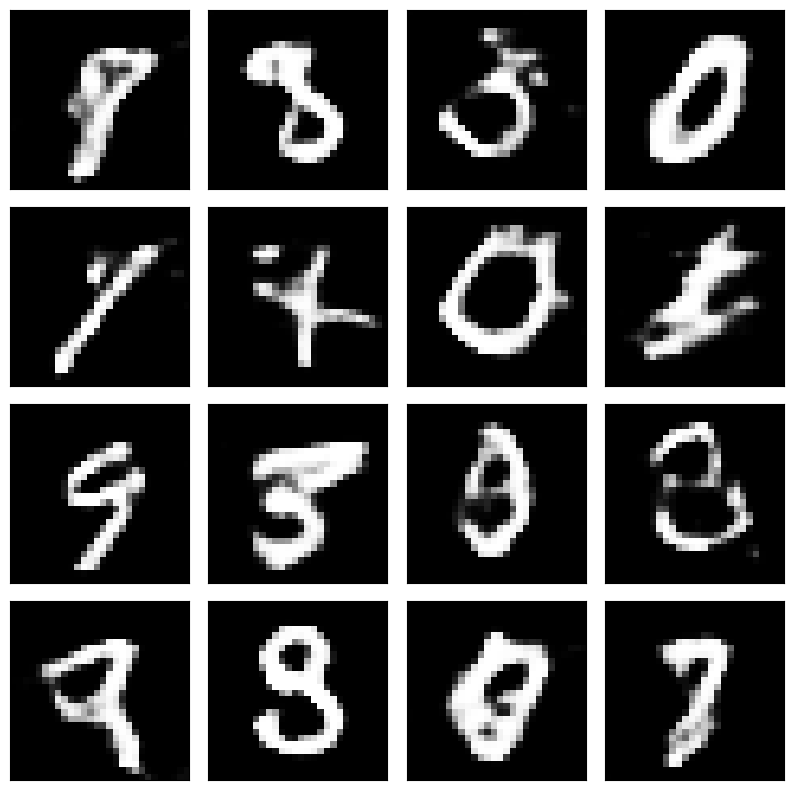




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 49; D_loss=1.015112280845642; G_loss=1.6262799501419067
(16, 28, 28, 1)
EPOCH # 50
Generated images:


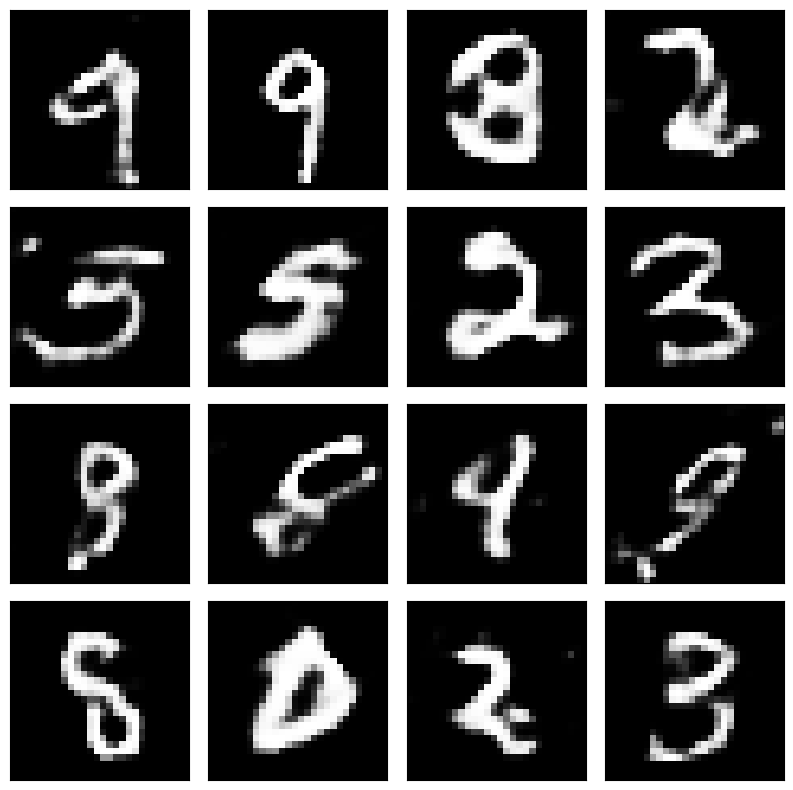




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 50; D_loss=0.9987080693244934; G_loss=1.8175623416900635
(16, 28, 28, 1)
EPOCH # 51
Generated images:


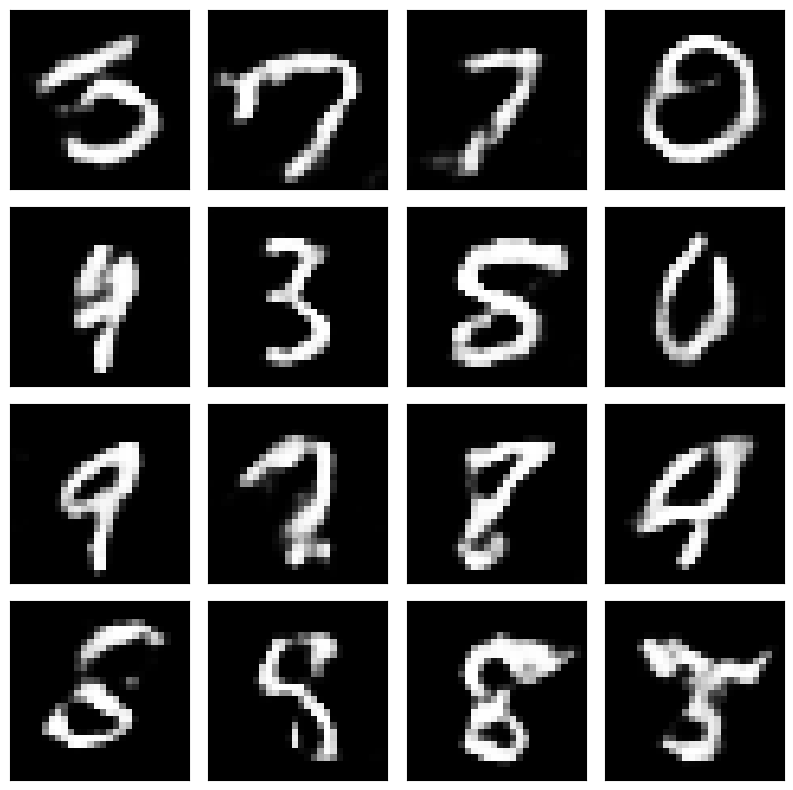




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 51; D_loss=0.9078003764152527; G_loss=1.7107255458831787
(16, 28, 28, 1)
EPOCH # 52
Generated images:


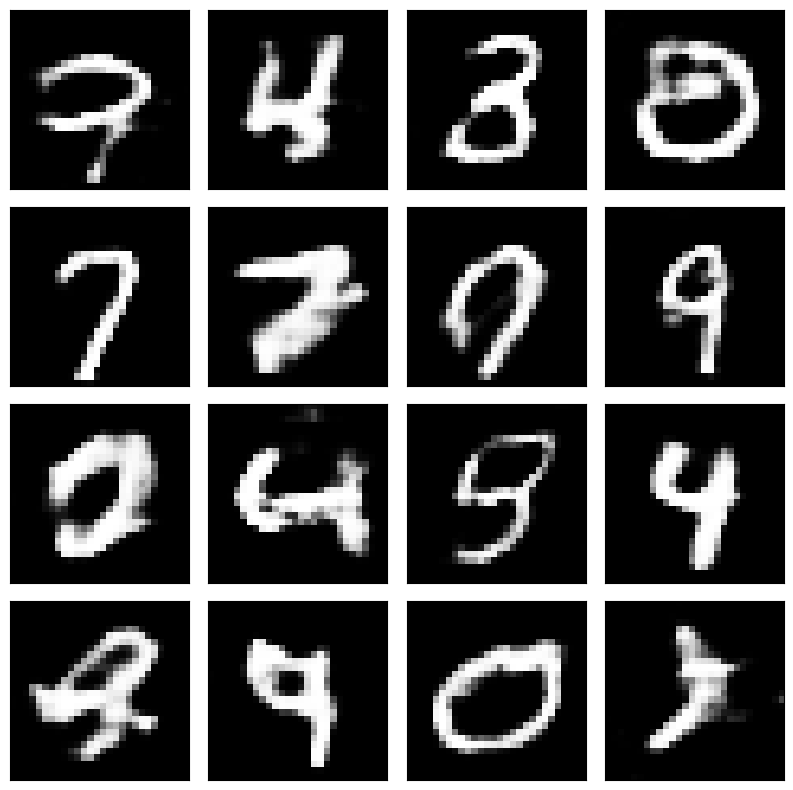




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 52; D_loss=0.7881884574890137; G_loss=1.94495689868927
(16, 28, 28, 1)
EPOCH # 53
Generated images:


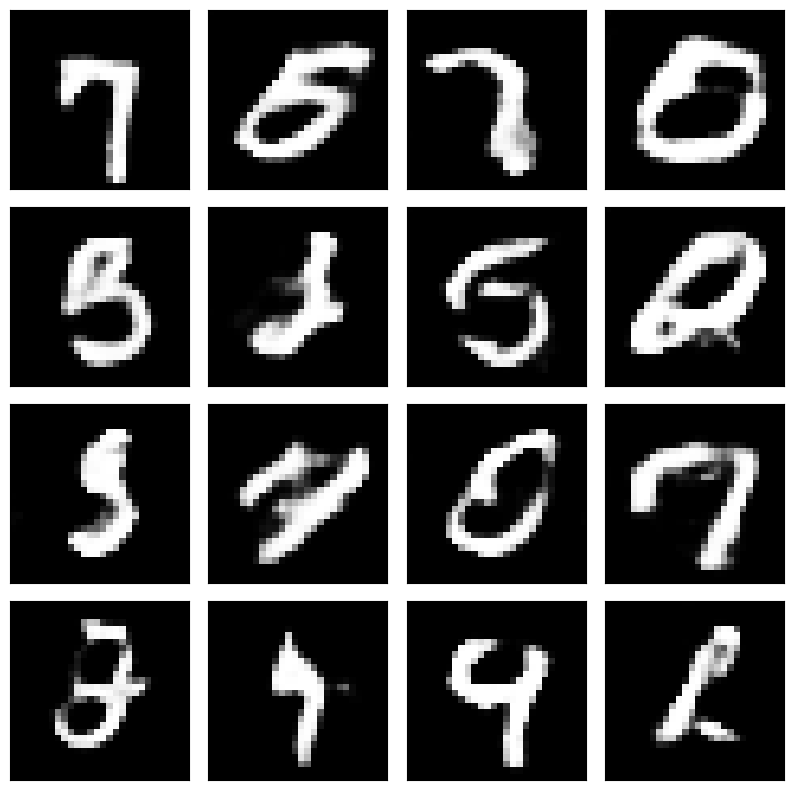




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 53; D_loss=0.9439851641654968; G_loss=1.4163328409194946
(16, 28, 28, 1)
EPOCH # 54
Generated images:


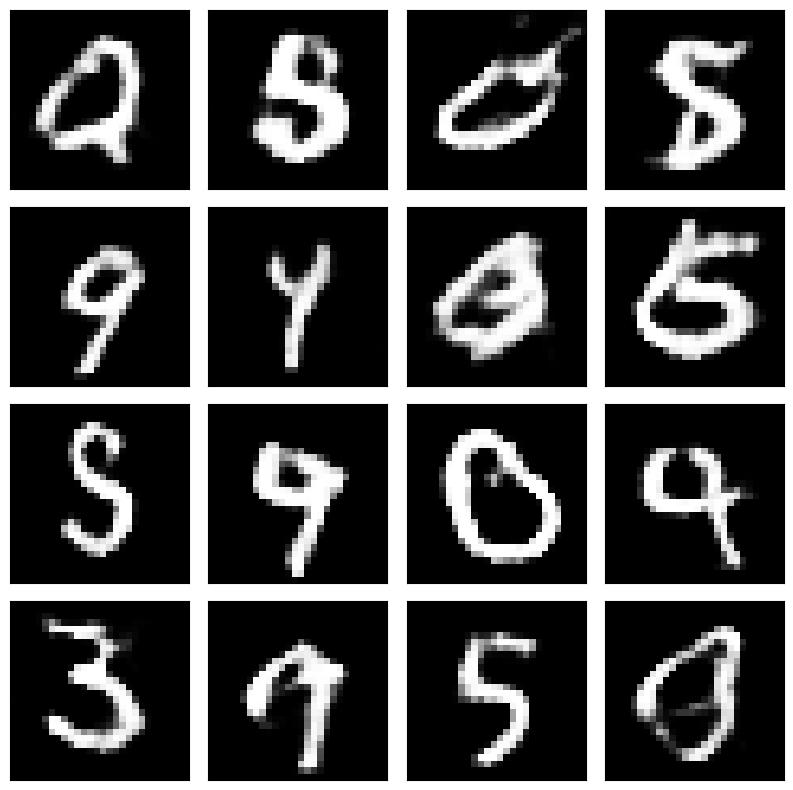




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 54; D_loss=0.8304705619812012; G_loss=1.6907176971435547
(16, 28, 28, 1)
EPOCH # 55
Generated images:


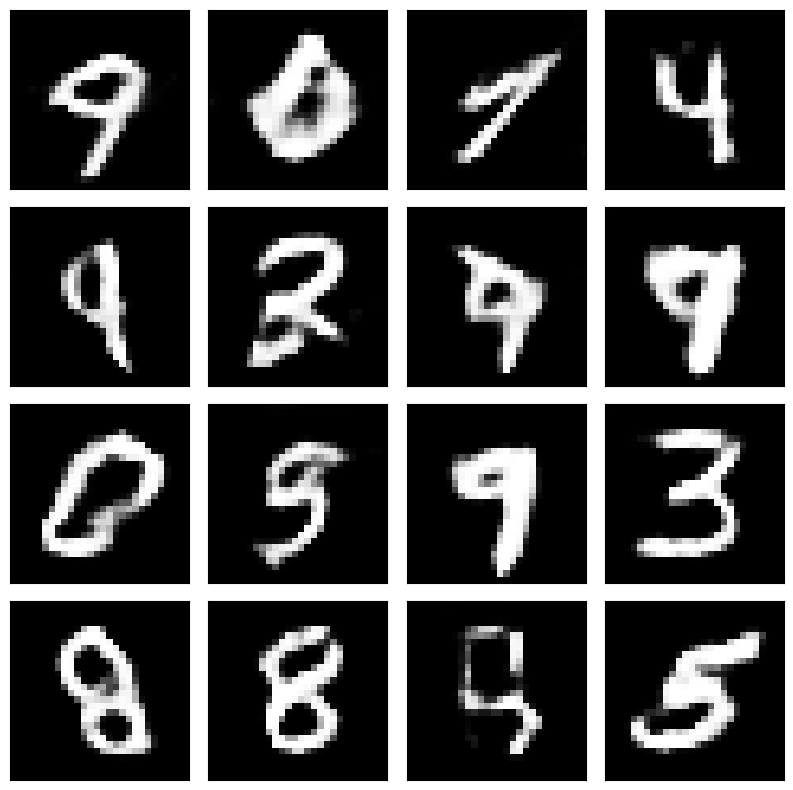




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 55; D_loss=0.9034223556518555; G_loss=1.6484767198562622
(16, 28, 28, 1)
EPOCH # 56
Generated images:


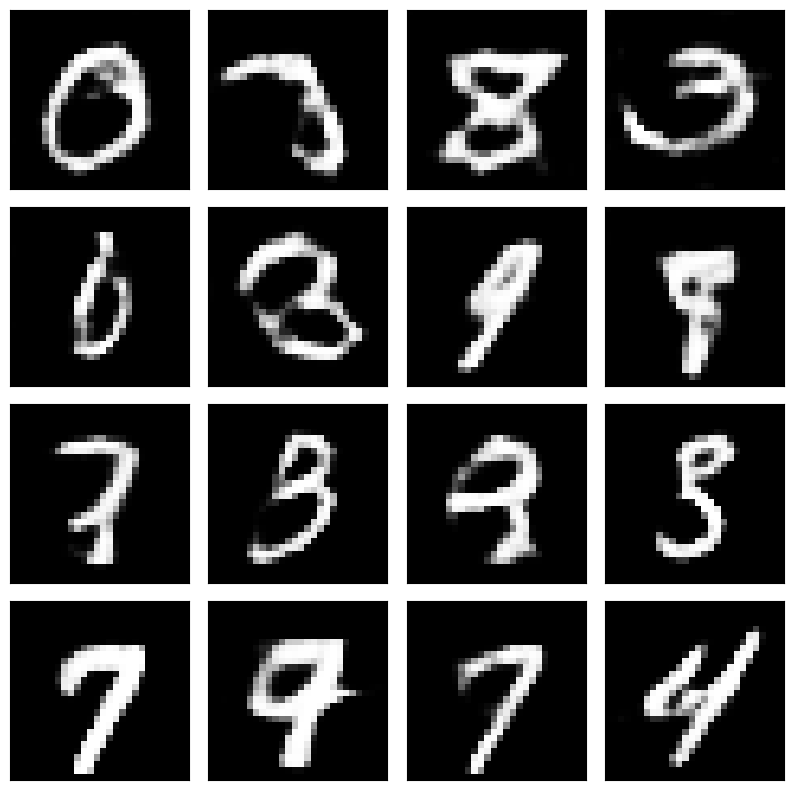




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 56; D_loss=1.1337718963623047; G_loss=1.4695769548416138
(16, 28, 28, 1)
EPOCH # 57
Generated images:


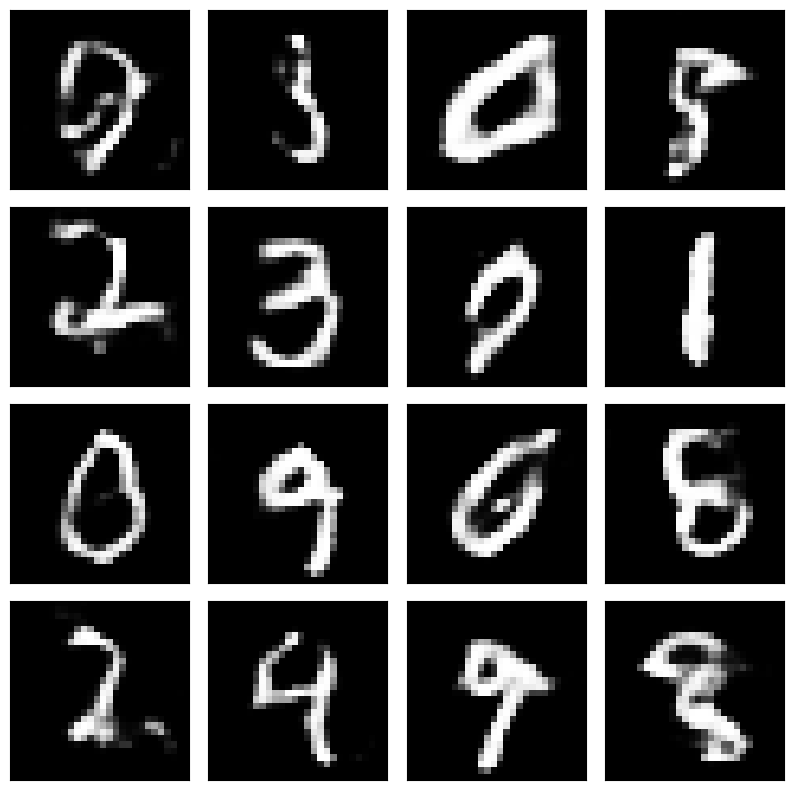




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 57; D_loss=0.9299846887588501; G_loss=1.5233497619628906
(16, 28, 28, 1)
EPOCH # 58
Generated images:


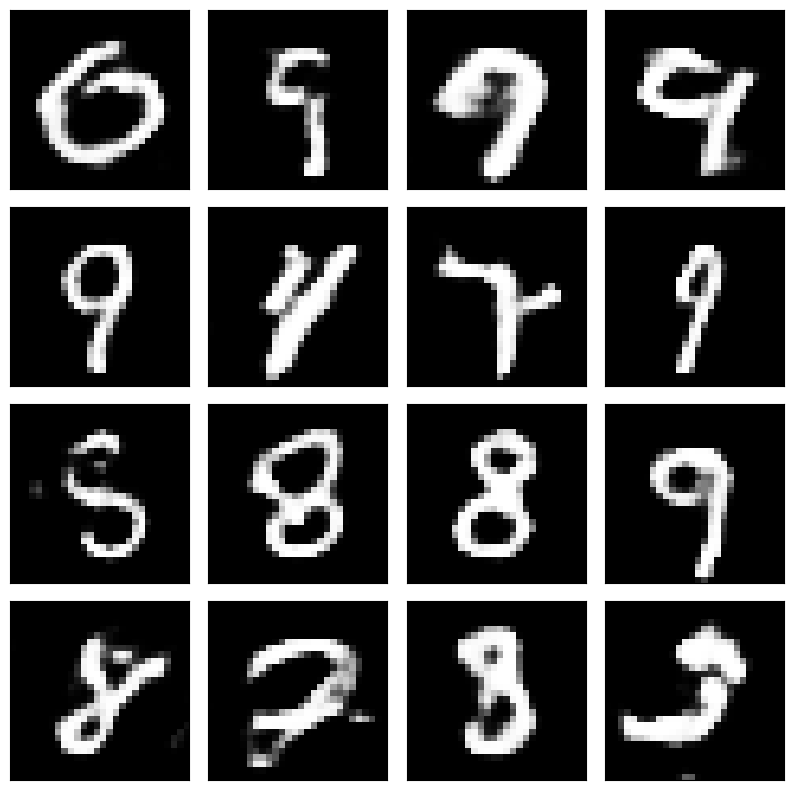




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 58; D_loss=0.8914203643798828; G_loss=1.494428277015686
(16, 28, 28, 1)
EPOCH # 59
Generated images:


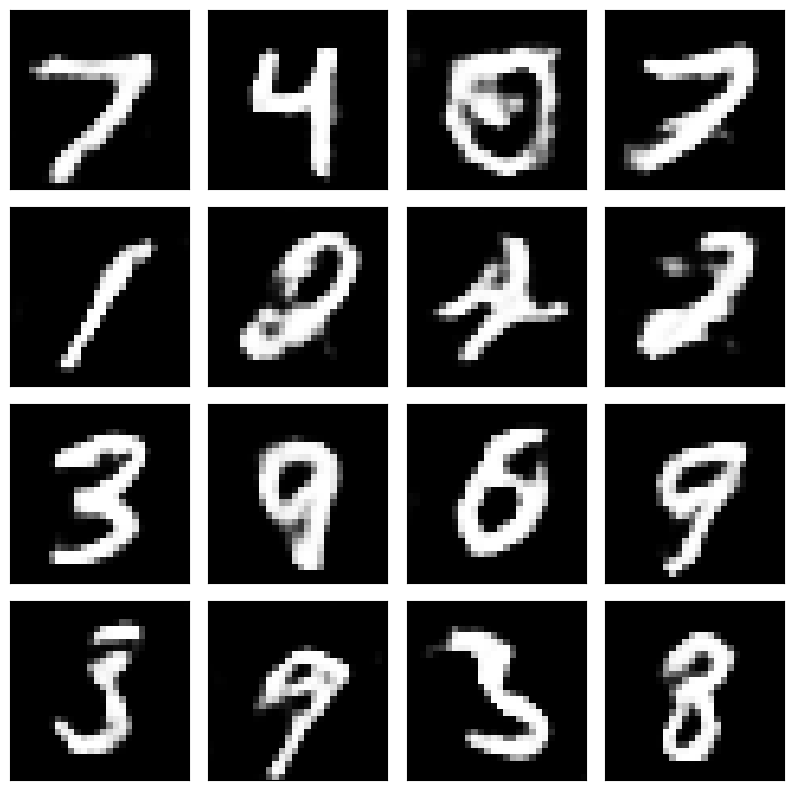




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 59; D_loss=0.9455850124359131; G_loss=1.6418145895004272
(16, 28, 28, 1)
EPOCH # 60
Generated images:


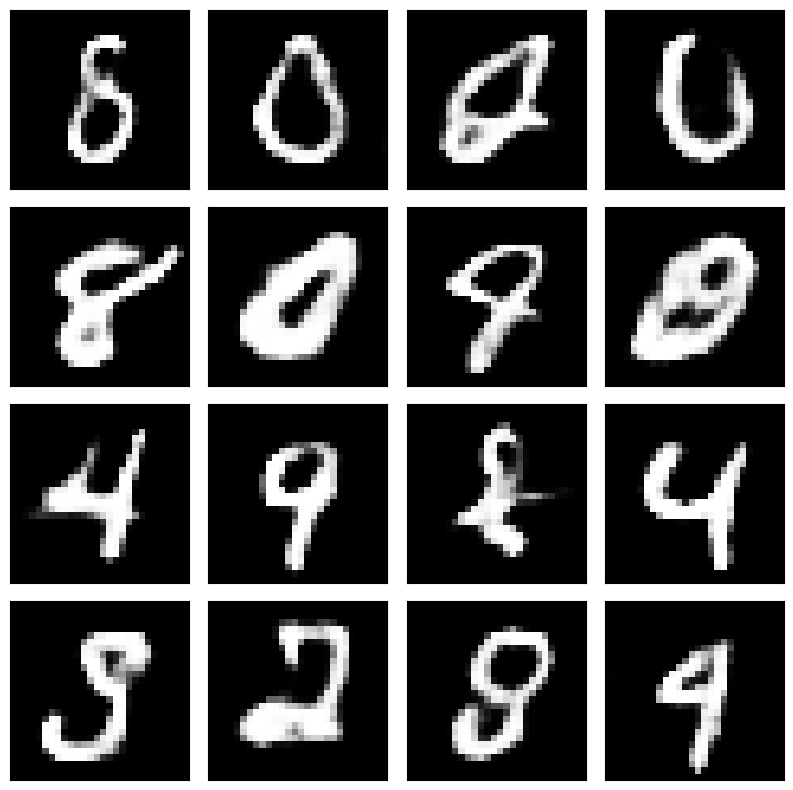




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 60; D_loss=0.9408636093139648; G_loss=1.4737778902053833


In [89]:




#TRAINING LOOP

for n_epoch in range(EPOCHS + 1):

    generated_examples = generator(tf.random.normal((16, noise_dim)), training=False)
    print(generated_examples.shape)
    print("EPOCH #", n_epoch)
    print("Generated images:")
    visualize_generated_images(generated_examples)

    for ith_batch in range(n_batches):

        batch = train_images[ith_batch * 256: (ith_batch + 1) * 256]
        noise = tf.random.normal((BATCH_SIZE, noise_dim))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator(noise, training=True)

            real_output = discriminator(batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        #Compute grads
        G_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        D_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        #update params
        G_optimizer.apply_gradients(zip(G_grads, generator.trainable_variables))
        D_optimizer.apply_gradients(zip(D_grads, discriminator.trainable_variables))



    manager.save(checkpoint_number=n_epoch)
    print("\n\n")
    print("!: Checkpoint has been saved in ", checkpoint_dir)

    print(f"Epoch {n_epoch}; D_loss={disc_loss}; G_loss={gen_loss}")


In [90]:
generator.save(base_dir + "generator_trained60eps")
discriminator.save(base_dir + "discriminator_trained60eps")

## Let's see the generated images after training

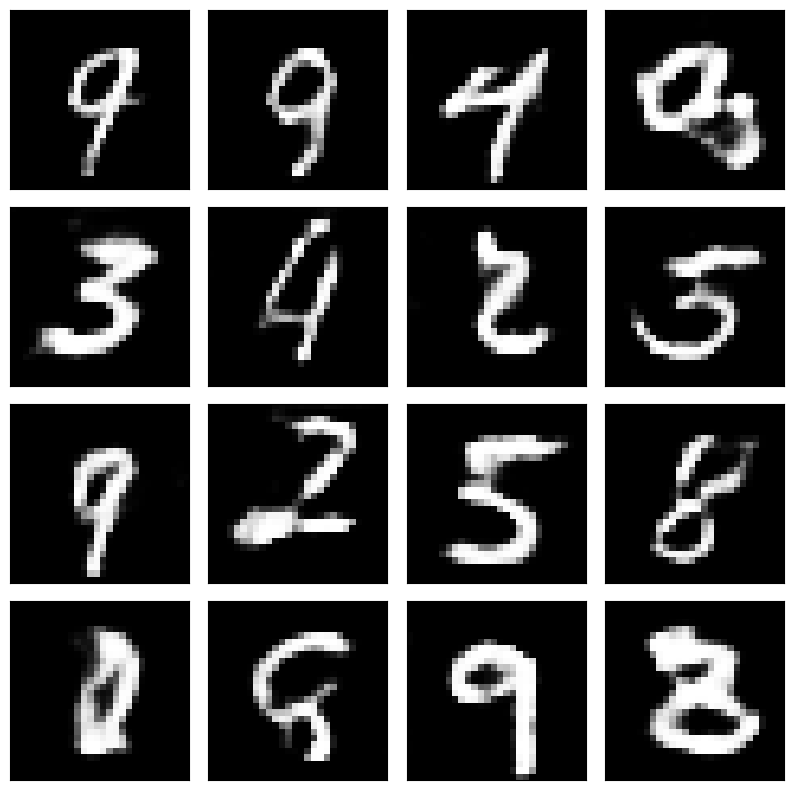

In [91]:
noise = tf.random.normal((16, 100))

pics = generator(noise)


visualize_generated_images(pics, 16)